In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull as pp
import noise_models as noise
import fig_plot as fplot
import model_fitting as fit

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

dataset   zipper kinase model
0     L_250     EE_L     wt  push
1     E_250     EE_E     wt  push
2    RR_250       RR     wt  push
3   S+E_250      S+E     wt  push
4       375  generic    375  push
5       419  generic    419  push
6  421_1000  generic    421  push

144282
144282


WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp
dataset                                                                 
L_250    0      7125.523438   708.402954   1259.858032          1.778448
         1      6116.868164  5363.838867  10856.771484          2.024067
         2      4704.967773   467.877228    234.306183          0.500786
         3      3216.373047  5016.458008    974.202454          0.194201
         4       853.554443   752.502441    446.738892          0.593671
...                     ...          ...           ...               ...
421_1000 19384  5514.650879  1931.040527    181.870697          0.094183
         19385  3486.172852  2970.319092     33.029129          0.011120
         19386  2133.772949  1901.190063    250.710464          0.131870
         19387   698.751587  1149.985474    118.818314          0.103322
         19388   711.345825   616.651672     86.492981          0.140262

[144282 rows x 4 columns]

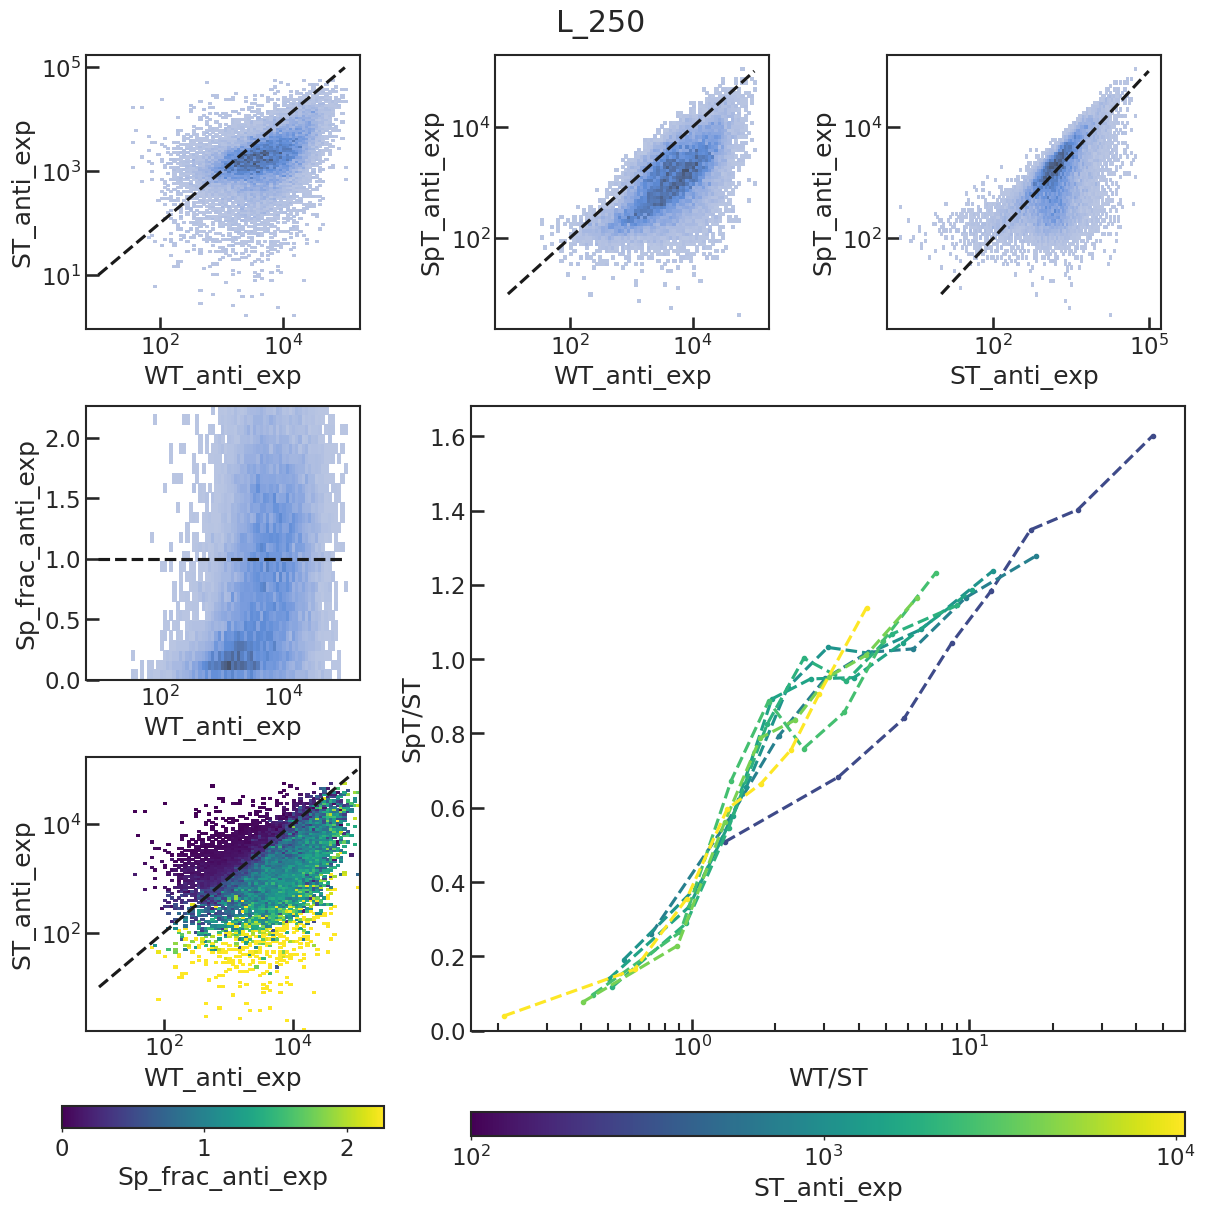

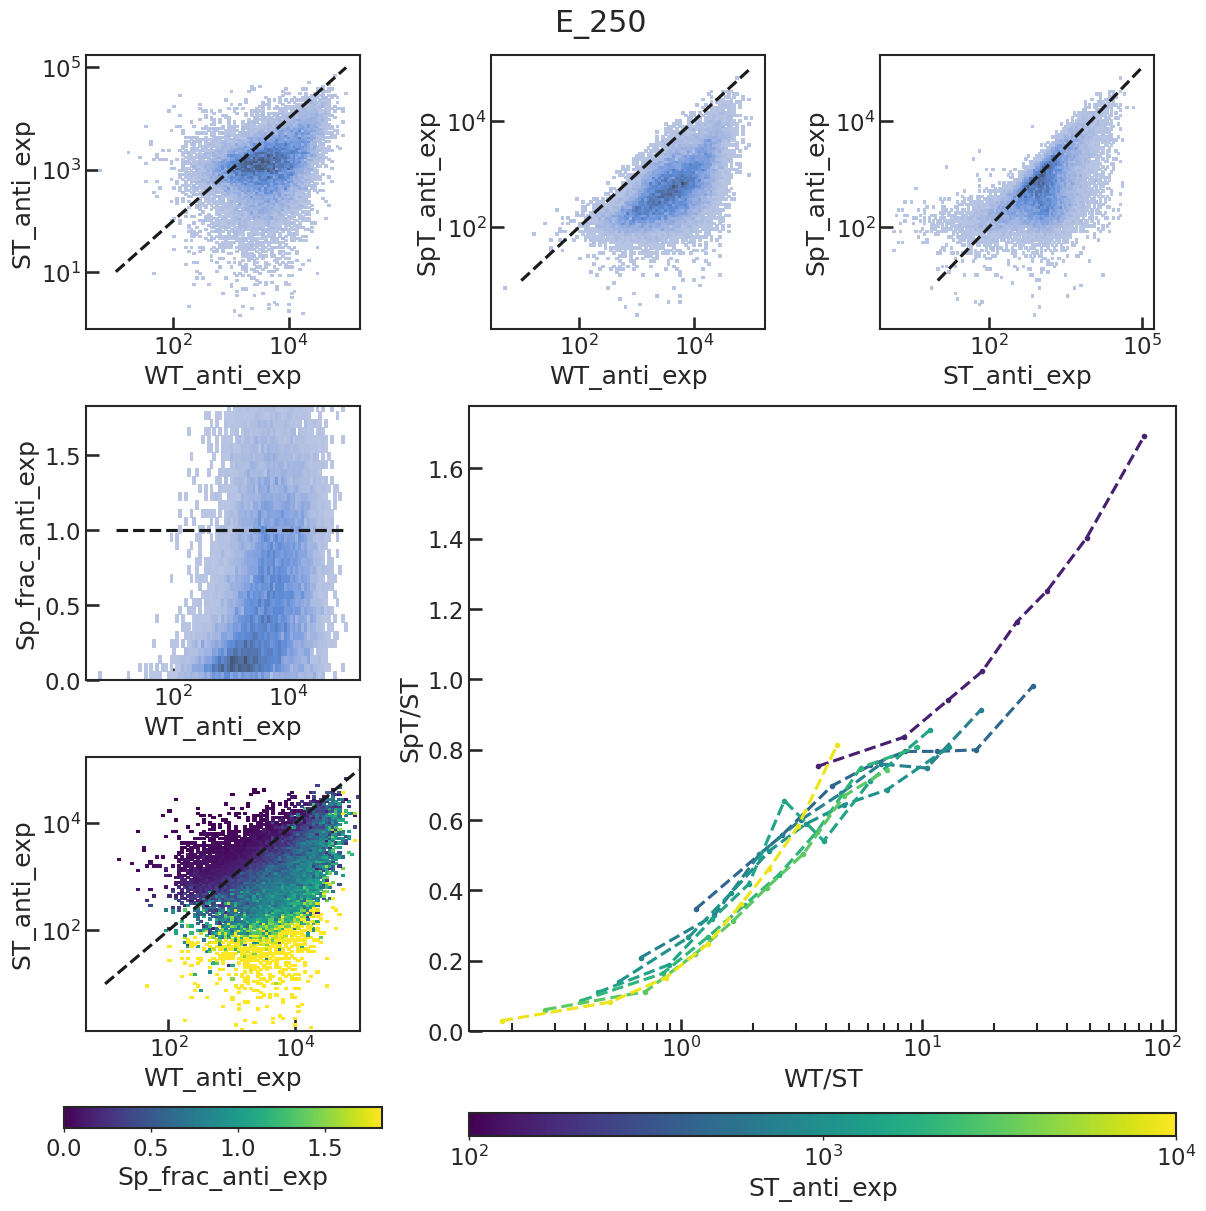

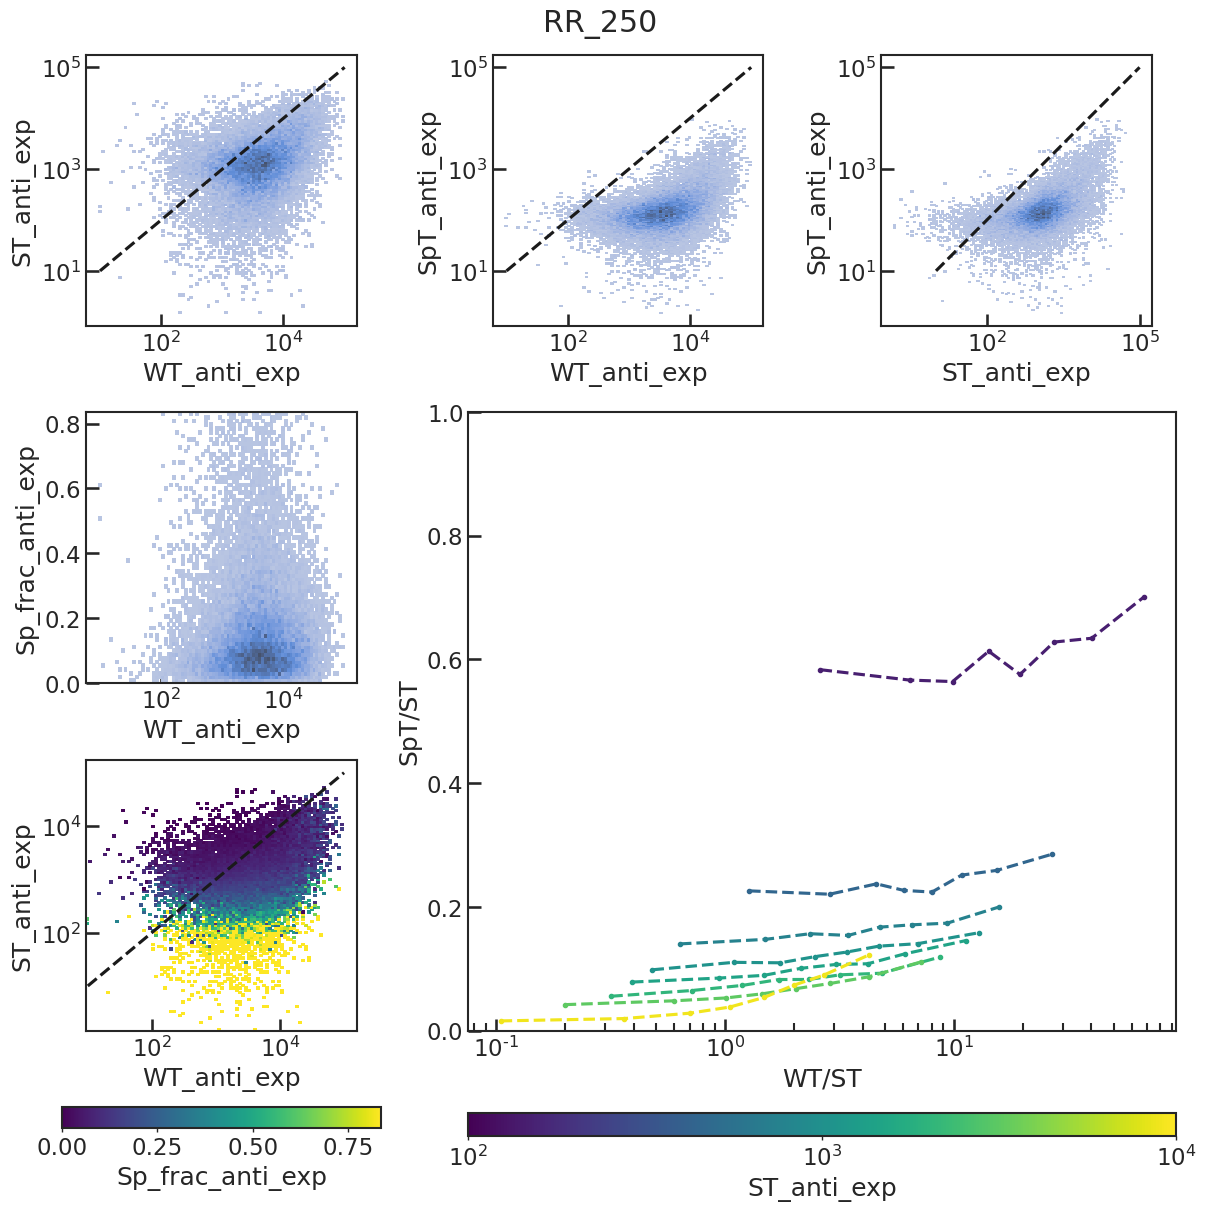

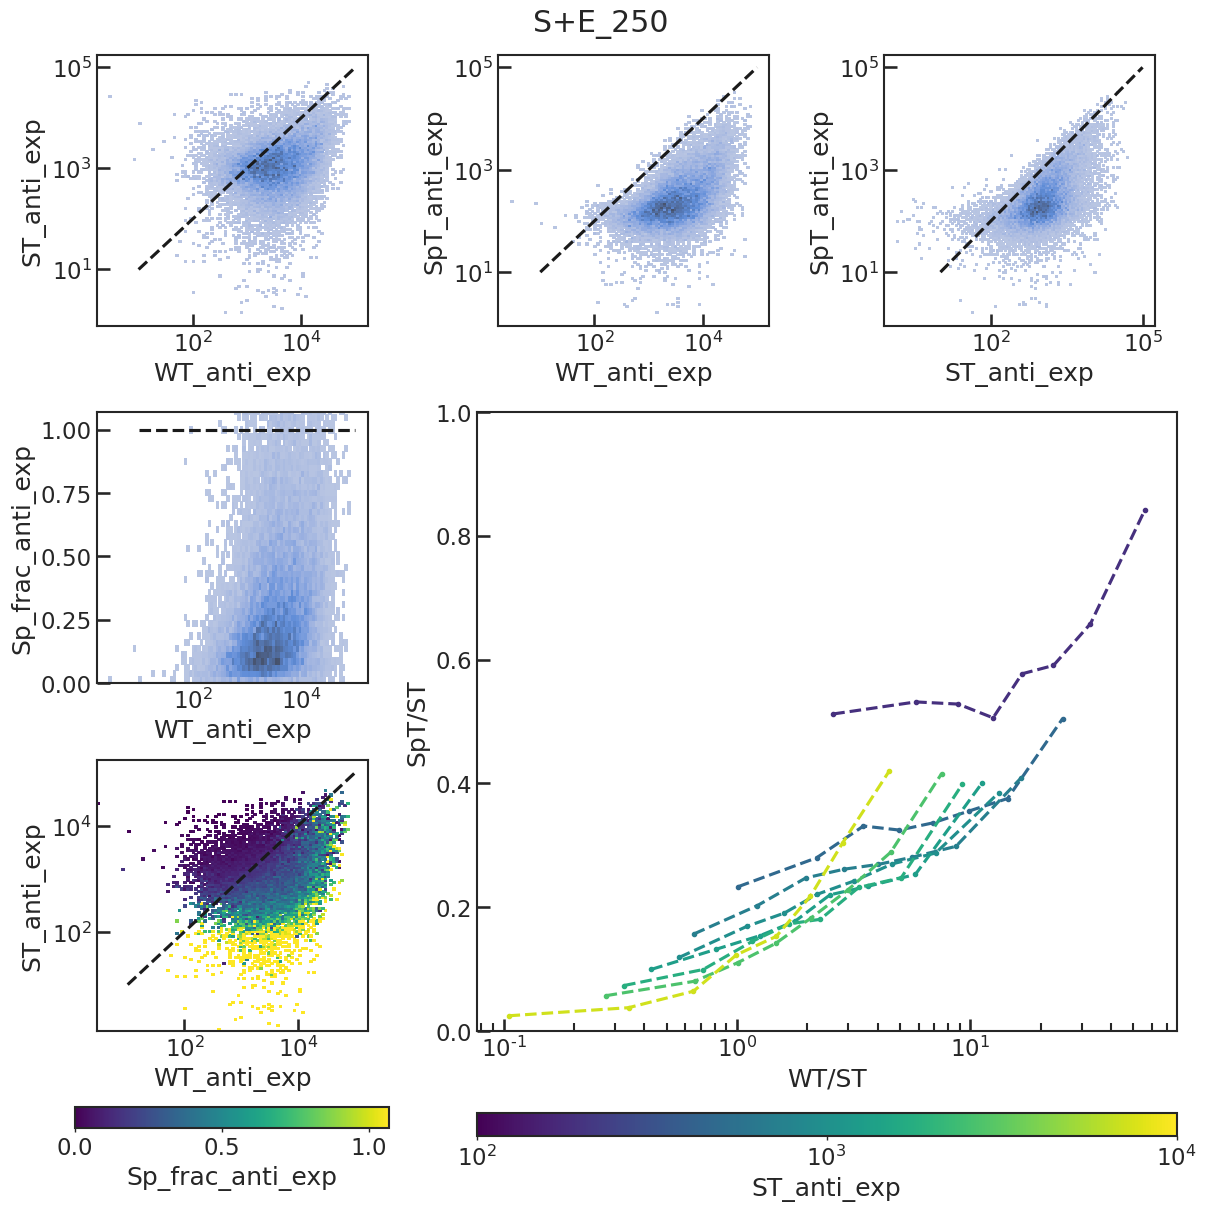

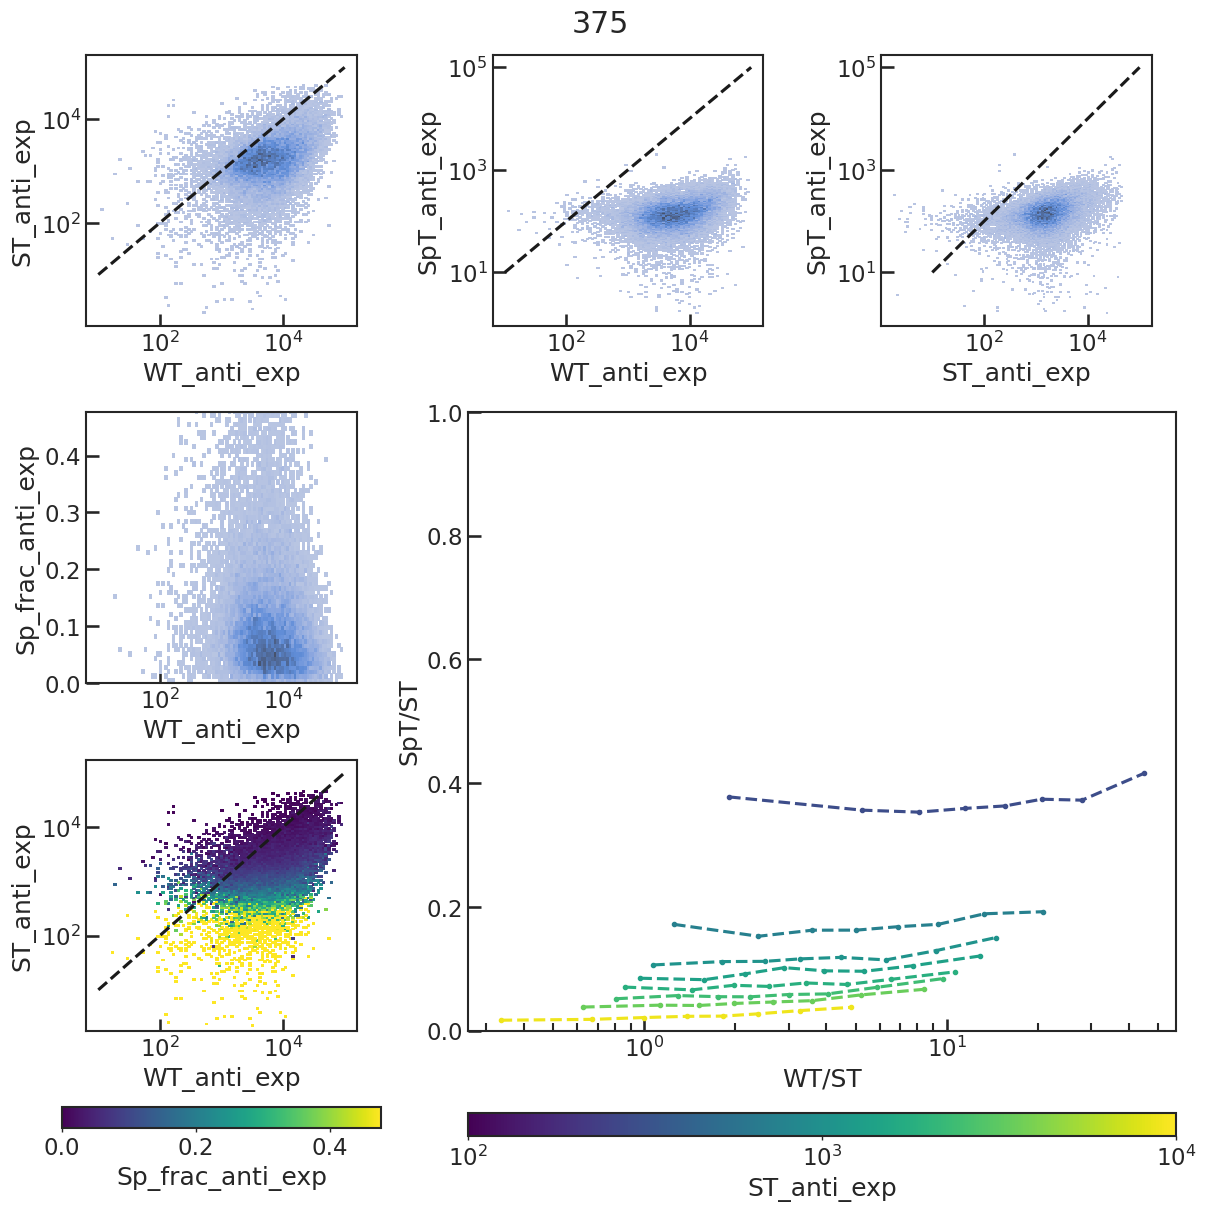

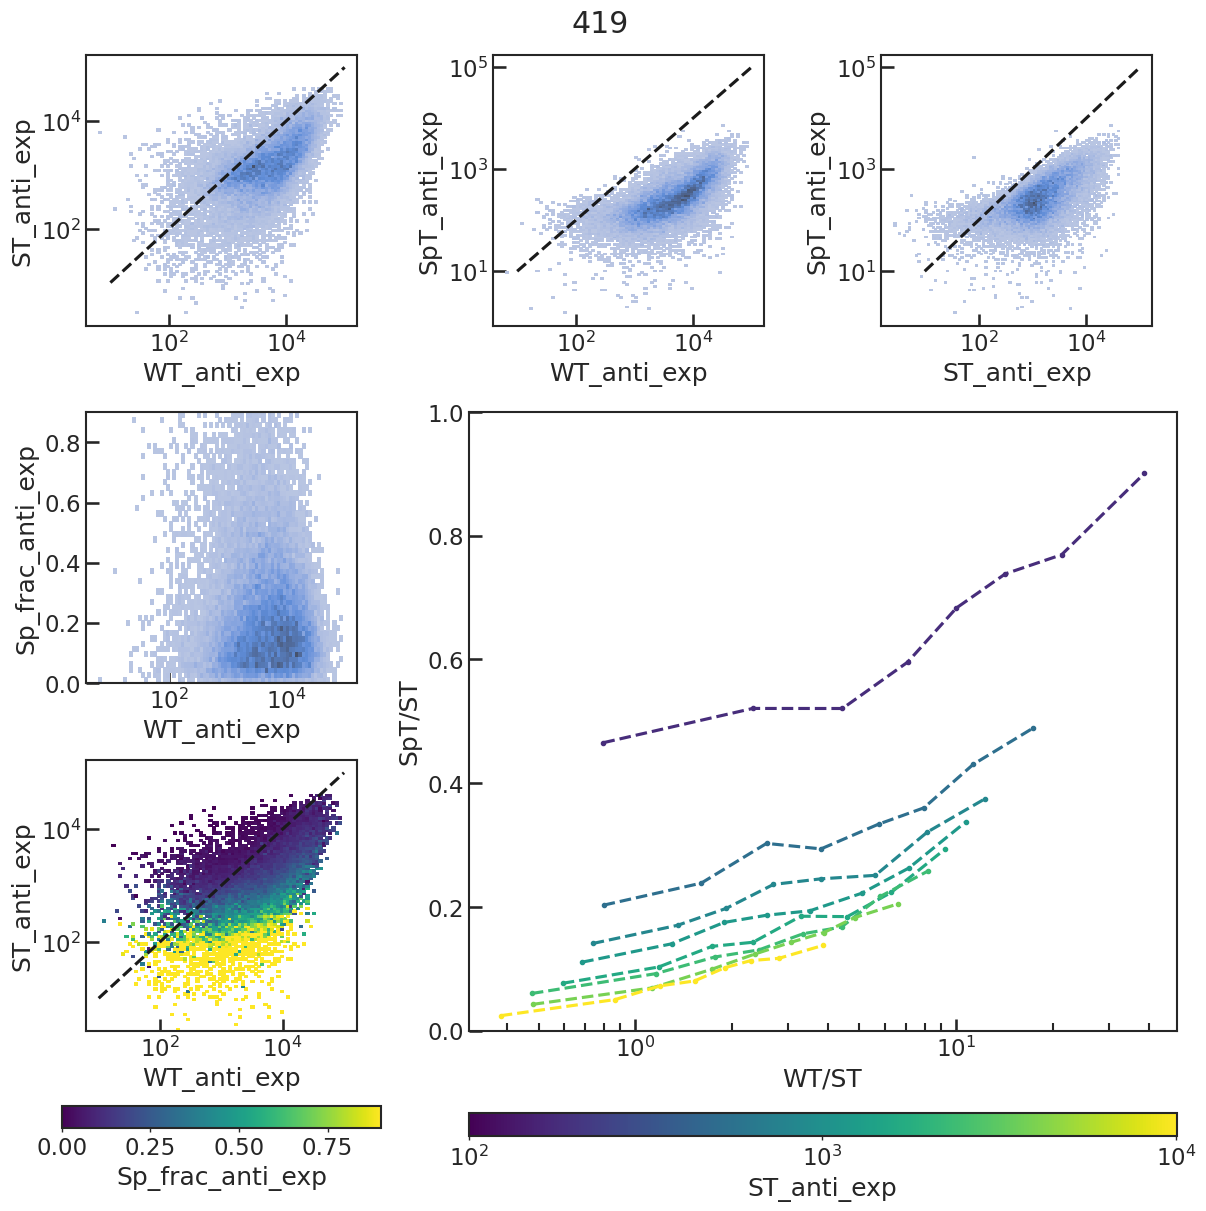

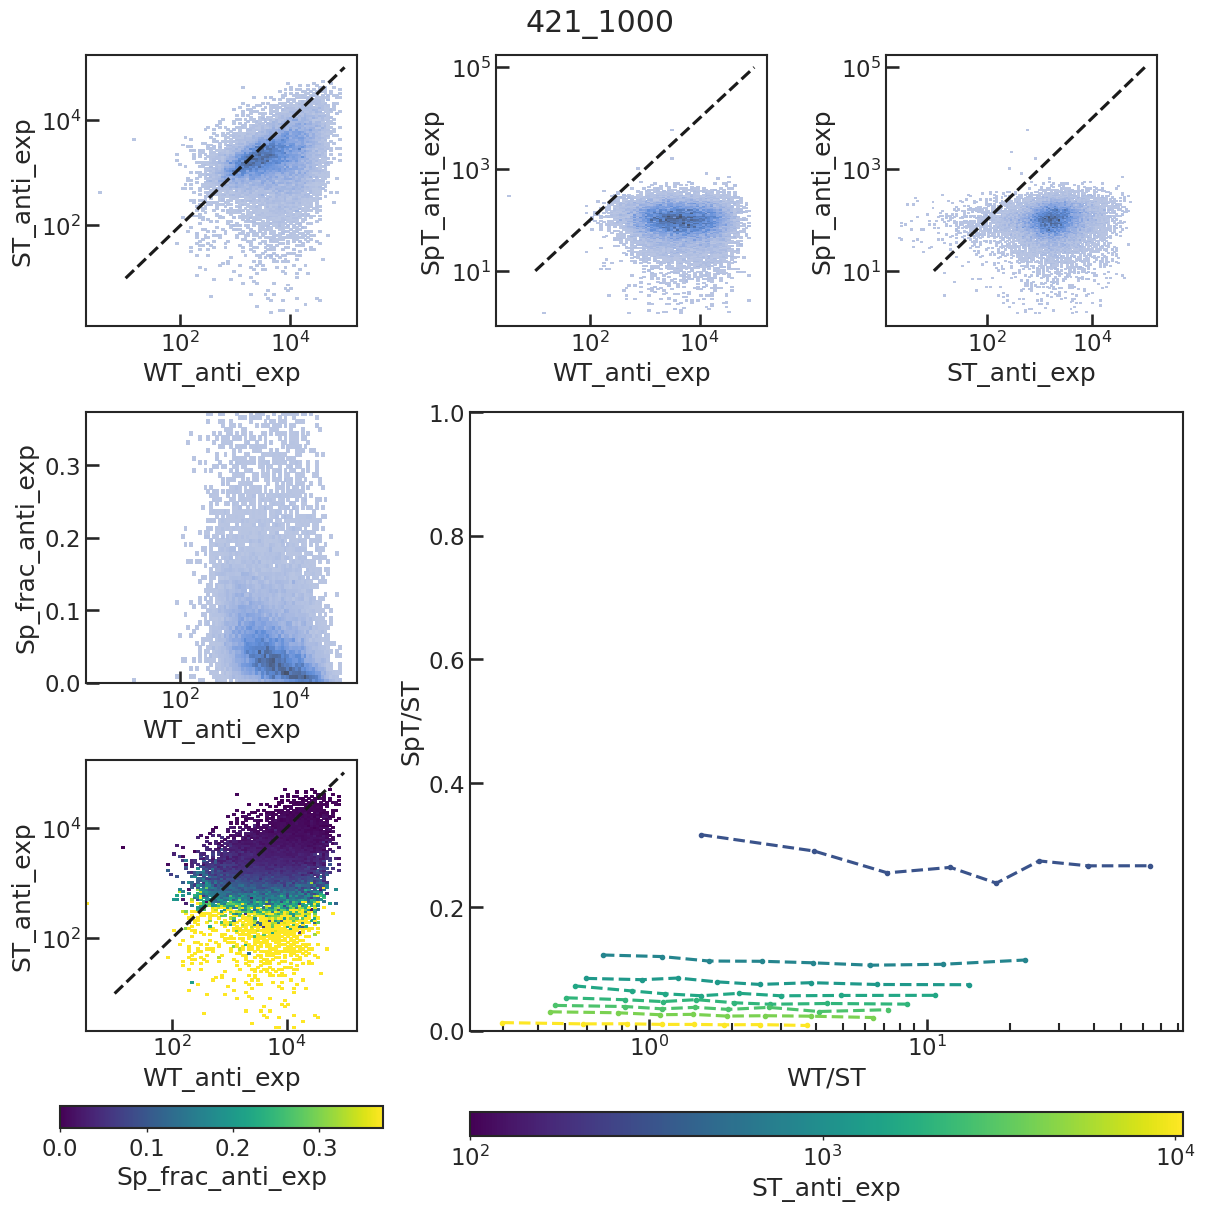

In [28]:
# data_label = '210620'

# dataset, zipper variant, kinase variant, model
# s_list = [
#     ['E+E', 'E+E', 'wt', 'push'],
#     ['I+E', 'I+E', 'wt', 'push'],
#     ['RR+A', 'RR+A', 'wt', 'push'],
#     ['S+A', 'S+A', 'wt', 'push'],
#     ['S+E', 'S+E', 'wt', 'push'],
#     ['wt', 'generic', 'wt', 'push'],
#     ['KD', 'generic', 'KD', 'push'],
#     ['R460A', 'generic', 'R460A', 'push'],
#     ['R460K', 'generic', 'R460K', 'push'],
#     ['R460S', 'generic', 'R460S', 'push'],
#          ]


data_label = '210728'

s_list = [
    ['L_250', 'EE_L', 'wt', 'push'],
    ['E_250', 'EE_E', 'wt', 'push'],
    ['RR_250', 'RR', 'wt', 'push'],
    ['S+E_250', 'S+E', 'wt', 'push'],
    ['375', 'generic', '375', 'push'],
    ['419', 'generic', '419', 'push'],
    ['421_1000', 'generic', '421', 'push']
         ]


df_info = pd.DataFrame(s_list, columns=['dataset', 'zipper', 'kinase', 'model'])
     
display(df_info)

df_list = []
for index, row in df_info.iterrows():
    df = pd.read_csv("../data/{0}_push/{1}.csv".format(data_label, row['dataset']))    
    df['dataset'] = row['dataset']      
    df_list.append(df)
    
    
df = pd.concat(df_list).drop("Unnamed: 0", axis=1, errors='ignore')


df.set_index("dataset", inplace=True, append=True)
df = df.reorder_levels(df.index.names[::-1])


print(len(df.index))
df = df[(df[df.columns[:-1]] > 0).all(axis=1)].rename(columns={'Flag : APC - Area': 'WT_anti_exp', 'WT_anti': 'WT_anti_exp', 'ST_anti': 'ST_anti_exp', 'SpT_anti': 'SpT_anti_exp'})
print(len(df.index))

df['Sp_frac_anti_exp'] = df['SpT_anti_exp'] / df['ST_anti_exp']



display(df)


for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.query("dataset==@dataset").copy()

    fig = plt.figure(constrained_layout=True, figsize=(12, 12))
    
    
    gs = fig.add_gridspec(3, 3)
    
    ax = fig.add_subplot(gs[0, 0])
    
    sns.histplot(df_tmp, x='WT_anti_exp', y='ST_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_aspect(1 / ax.get_data_ratio())
    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 1])
        
    sns.histplot(df_tmp, x='WT_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_aspect(1 / ax.get_data_ratio())
    
    ##########################################################
    
    ax = fig.add_subplot(gs[0, 2])
    
    sns.histplot(df_tmp, x='ST_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_aspect(1 / ax.get_data_ratio())
    
    ##########################################################

    ax = fig.add_subplot(gs[1, 0])
    
    sns.histplot(df_tmp, x='WT_anti_exp', y='Sp_frac_anti_exp', 
                 log_scale=(True, False), ax=ax)
    
    ax.hlines(1e0, xmin=1e1, xmax=1e5, color='k', ls='--')
        
    ax.set_ylim(0, df_tmp['Sp_frac_anti_exp'].quantile(0.95))
    
    ax.set_aspect(1 / ax.get_data_ratio())
    
    ##########################################################
    
    ax = fig.add_subplot(gs[2, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 'WT_anti_exp', 'ST_anti_exp', 'Sp_frac_anti_exp')
    
    ##########################################################
    
    ax = fig.add_subplot(gs[1:3, 1:3])
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 
                                 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_exp')
    
    ##########################################################

    fig.suptitle(dataset)

    plt.show()
    
    


Num Cells: 17924 Points per bin: 10 Num Bins: 42
Num Cells: 22377 Points per bin: 10 Num Bins: 47


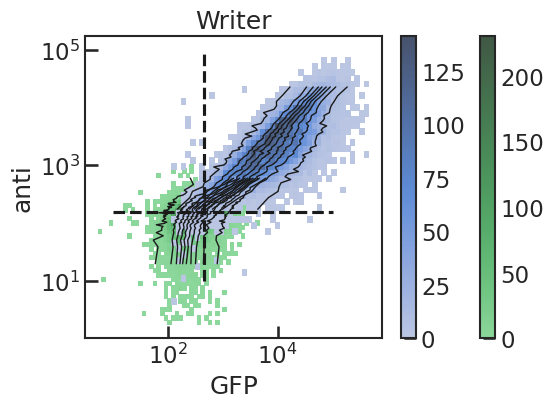

Num Cells: 10802 Points per bin: 10 Num Bins: 32
Num Cells: 22377 Points per bin: 10 Num Bins: 47


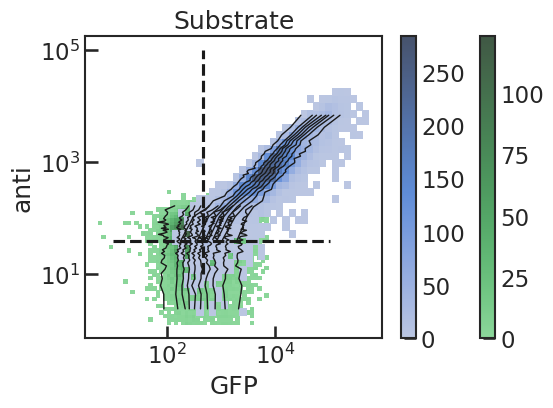

Num Cells: 10802 Points per bin: 10 Num Bins: 32
Num Cells: 22377 Points per bin: 10 Num Bins: 47


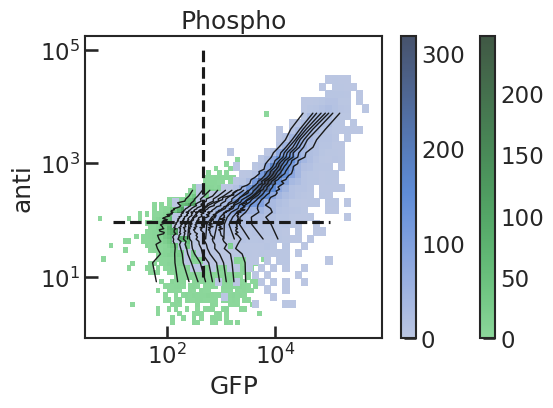

Num Cells: 10802 Points per bin: 10 Num Bins: 32
Num Cells: 33179 Points per bin: 10 Num Bins: 57


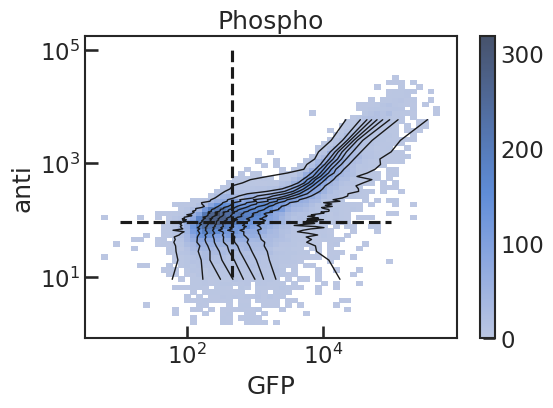

Num Cells: 10802 Points per bin: 10 Num Bins: 32
Num Cells: 22377 Points per bin: 10 Num Bins: 47


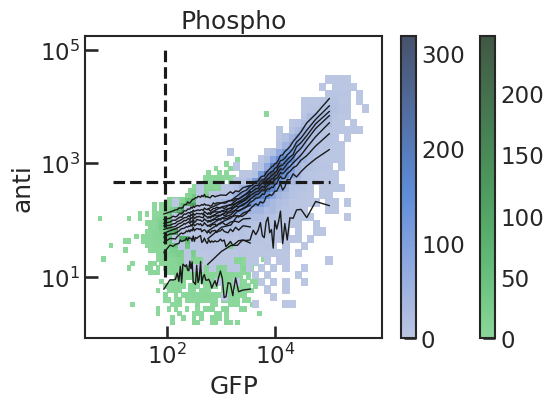

Num Cells: 33179 Points per bin: 10 Num Bins: 57


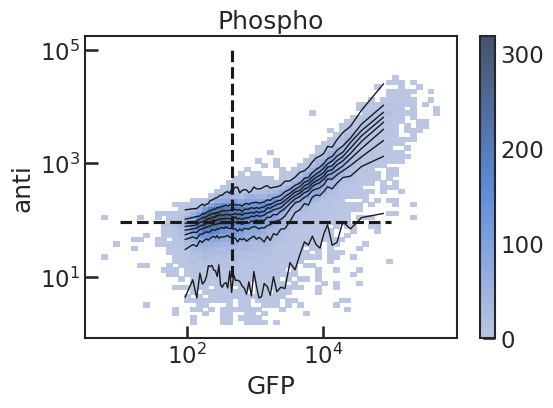

In [29]:
nbins_anti = 100
nbins_GFP = 100

writer_noise = noise.Anti2GFPNoise("../data/{}_noise/Flag noise.csv".format(data_label), 
                                   'Flag Antibody', 'GFP', ppbin=10, verbose=False)

empty_writer_noise = noise.Anti2GFPNoise("../data/{}_noise/Empty Cell.csv".format(data_label), 
                                   'Flag Antibody', 'GFP', ppbin=10, verbose=False)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_writer_noise.plot(ax, color='g')
writer_noise.plot(ax)

ax.set_title("Writer")

ax.hlines(10**np.mean(np.log10(empty_writer_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_writer_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()

    
substrate_noise = noise.Anti2GFPNoise("../data/{}_noise/Myc_Phospho noise.csv".format(data_label), 
                                   'Myc Antibody', 'GFP', ppbin=10, verbose=False)

empty_substrate_noise = noise.Anti2GFPNoise("../data/{}_noise/Empty Cell.csv".format(data_label), 
                                   'Myc Antibody', 'GFP', ppbin=10, verbose=False)



fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_substrate_noise.plot(ax, color='g')
substrate_noise.plot(ax)
ax.set_title("Substrate")

ax.hlines(10**np.mean(np.log10(empty_substrate_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_substrate_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


    
phospho_noise = noise.Anti2GFPNoise("../data/{}_noise/Myc_Phospho noise.csv".format(data_label), 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)

empty_phospho_noise = noise.Anti2GFPNoise("../data/{}_noise/Empty Cell.csv".format(data_label), 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

empty_phospho_noise.plot(ax, color='g')
phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


combined_phospho_noise = noise.Anti2GFPNoise("../data/{}_noise/Myc_Phospho noise.csv".format(data_label), 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)
combined_phospho_noise.add_cells(empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
combined_phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()



inverse_phospho_noise = noise.GFP2AntiNoise("../data/{}_noise/Myc_Phospho noise.csv".format(data_label), 
                                   'GFP', 'Phospho', ppbin=10, verbose=False)

inverse_empty_phospho_noise = noise.GFP2AntiNoise("../data/{}_noise/Empty Cell.csv".format(data_label), 
                                   'GFP', 'Phospho', ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

inverse_empty_phospho_noise.plot(ax, color='g')
inverse_phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_GFP())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_anti())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()



inverse_phospho_noise.add_cells(inverse_empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
inverse_phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()



2 0.2557711379860506 [0.05424365 0.04424365] 0
4 0.24528923882231085 [0.03443946 0.04424365] 0
6 0.20847846315786475 [0.17064371 0.25609049] 0
11 0.1034654573110122 [0.20324843 0.62406757] 0
19 0.08283636827816213 [0.06464485 0.31397901] 0
28 0.03566232497979571 [0.00572106 0.31397901] 0
117 0.021768649160142428 [0.00572106 0.33426915] 0
340 0.017996627493314377 [0.00105187 0.33426915] 0
1733 0.01690549524988072 [0.00105187 0.33762565] 0
2732 0.0168056807729578 [0.00213626 0.33762565] 0
3320 0.016784944394173662 [0.00186047 0.33762565] 0
3397 0.01677742252288994 [0.00186047 0.3375118 ] 0
3661 0.01677742252288983 [0.00186047 0.3374667 ] 0
3914 0.016596794859255692 [0.00131039 0.33692709] 0
4513 0.01659679485925547 [0.00131039 0.33691316] 0
4572 0.016595412524913034 [0.00131967 0.33691316] 0
     fun: 0.016595412524913034
 message: ['Maximum number of iteration reached']
    nfev: 8002
    nhev: 0
     nit: 2000
    njev: 0
  status: 0
 success: True
       x: array([0.00131967, 0.336913

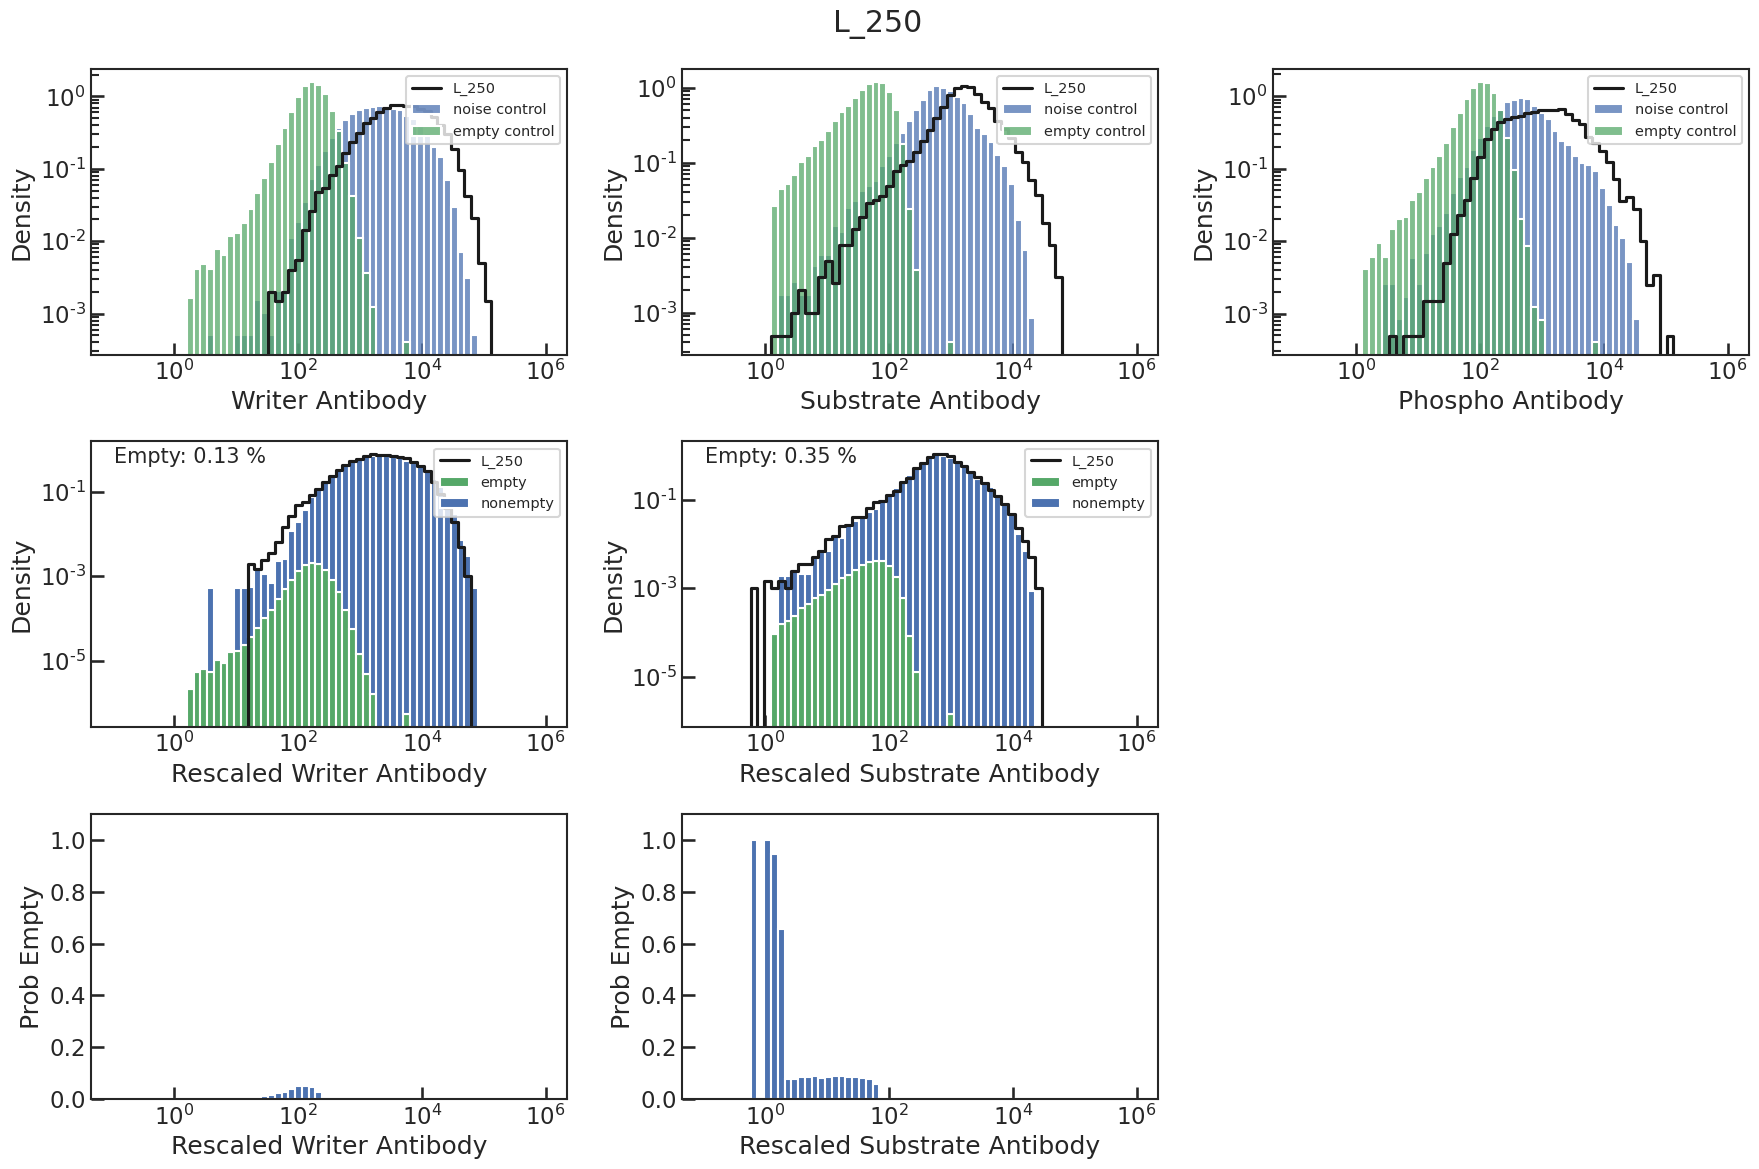

2 0.215028100823146 [0.05424365 0.04424365] 0
4 0.20286066584949042 [0.03443946 0.04424365] 0
6 0.18328561095379434 [0.17064371 0.25609049] 0
11 0.133425204035301 [0.20324843 0.62406757] 0
12 0.11767373395424541 [0.24088819 0.62406757] 0
14 0.09306999491762491 [0.06932197 0.45250135] 0
17 0.06956569183773356 [0.06932197 0.28835632] 0
20 0.01893069646092016 [0.00923342 0.28835632] 0
21 0.018782527542585525 [0.00923342 0.28070565] 0
340 0.016418296357064488 [0.00456423 0.28070565] 0
1100 0.01638632970032794 [0.00495575 0.28070565] 0
1216 0.01633206153622624 [0.00562059 0.28070565] 0
1772 0.016320899890007068 [0.00575735 0.28070565] 0
3016 0.016313341084004618 [0.00584998 0.28070565] 0
3253 0.01621856333782057 [0.00584998 0.28054255] 0
3260 0.01621030653841471 [0.00595116 0.28054255] 0
3428 0.0162047024115185 [0.00601984 0.28054255] 0
3649 0.016204702411517946 [0.00601984 0.28051436] 0
4746 0.015974287608775617 [0.00356328 0.27904098] 0
4805 0.015906324487512502 [0.00356328 0.27882106] 0


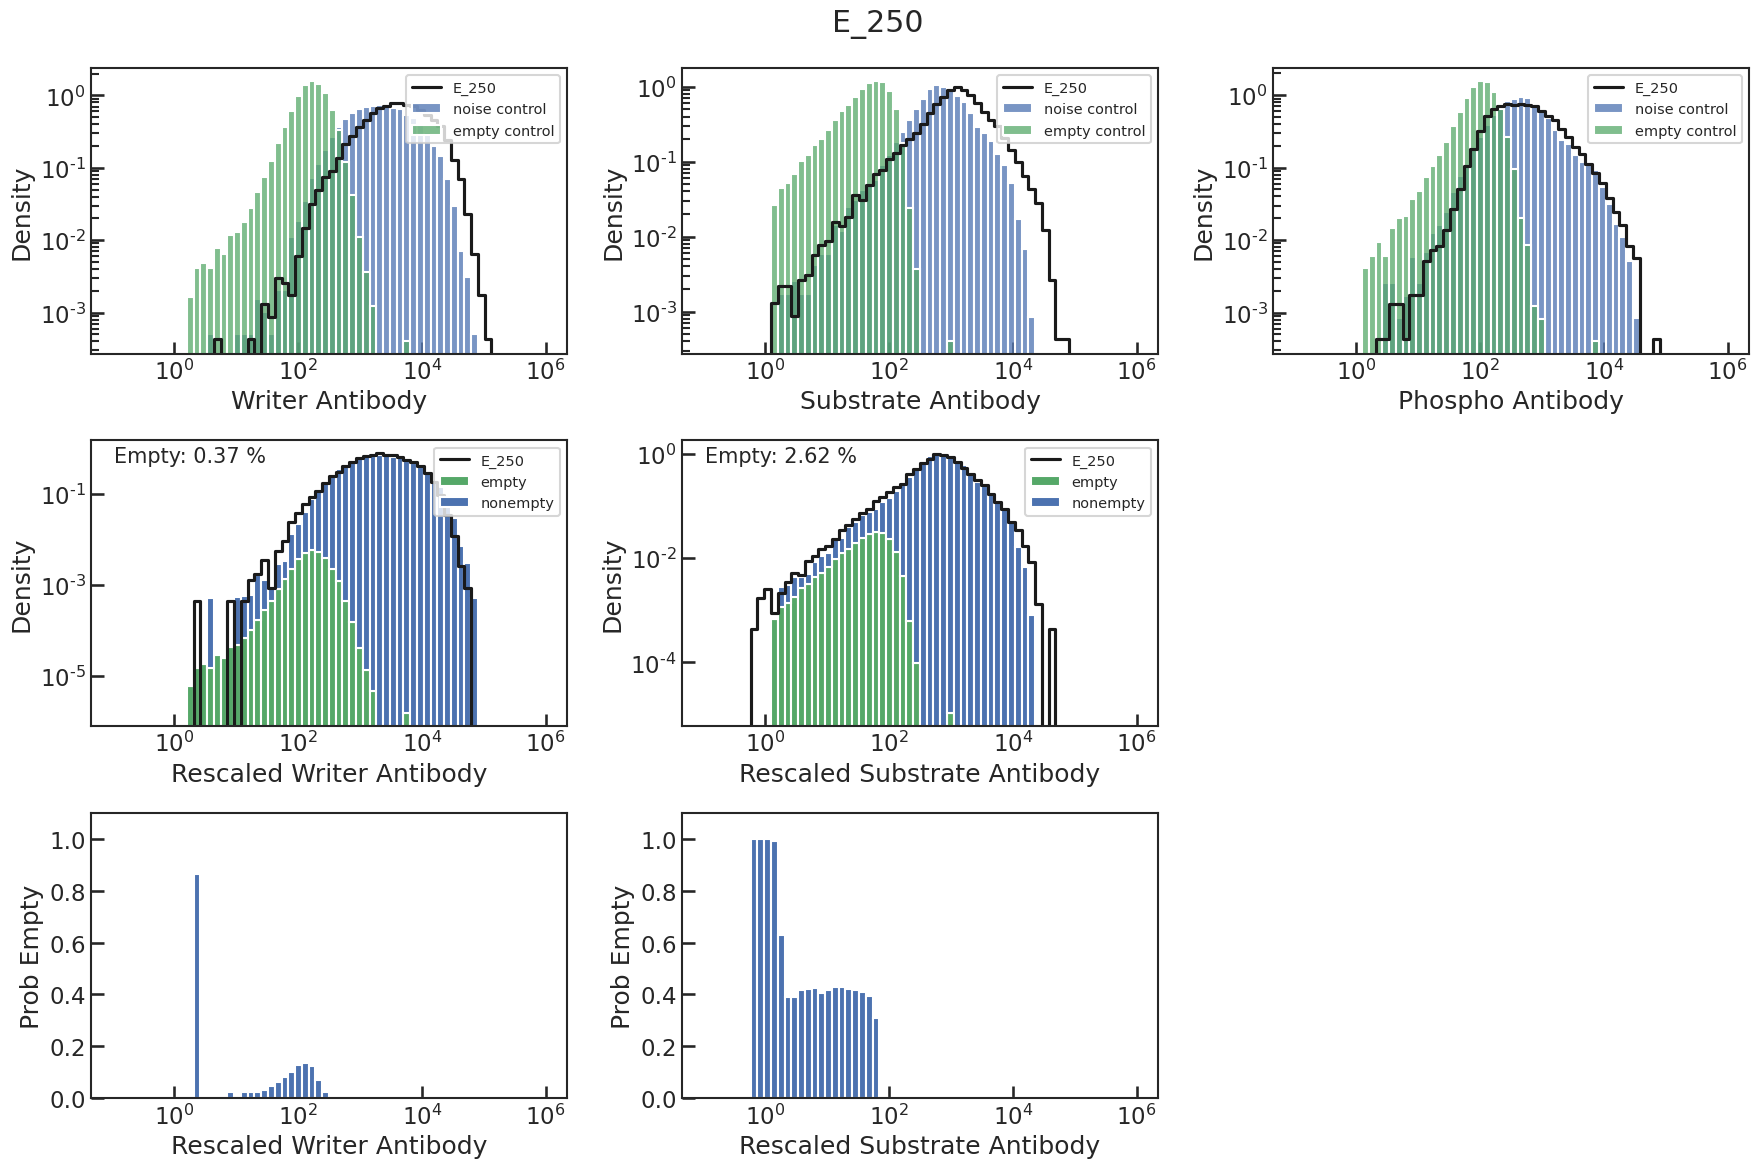

2 0.20383619446589457 [0.05424365 0.04424365] 0
4 0.19145148866325817 [0.03443946 0.04424365] 0
6 0.1693548657649366 [0.17064371 0.25609049] 0
11 0.16007337125877386 [0.20324843 0.62406757] 0
12 0.14083941335184347 [0.24088819 0.62406757] 0
14 0.12351597526224445 [0.06932197 0.45250135] 0
17 0.05896582584169416 [0.06932197 0.28835632] 0
20 0.04172057962592235 [0.00923342 0.28835632] 0
21 0.037086817826704865 [0.00923342 0.28070565] 0
32 0.036113994552391504 [0.01282311 0.28070565] 0
52 0.032079194232732755 [0.03595273 0.28070565] 0
118 0.031901038571463425 [0.01787617 0.27593119] 0
220 0.031132789456384202 [0.02066484 0.27593119] 0
317 0.030033061333814337 [0.02066484 0.2731218 ] 0
444 0.028967330405809788 [0.02457204 0.2731218 ] 0
1140 0.028608410346358637 [0.0261469 0.2731218] 0
2218 0.026376615096408873 [0.00609347 0.25003301] 0
2296 0.02350765152653178 [7.05955615e-05 2.50033015e-01] 0
2460 0.023358683813986758 [0.00062446 0.25003301] 0
2481 0.023061835974848732 [0.00062446 0.24824

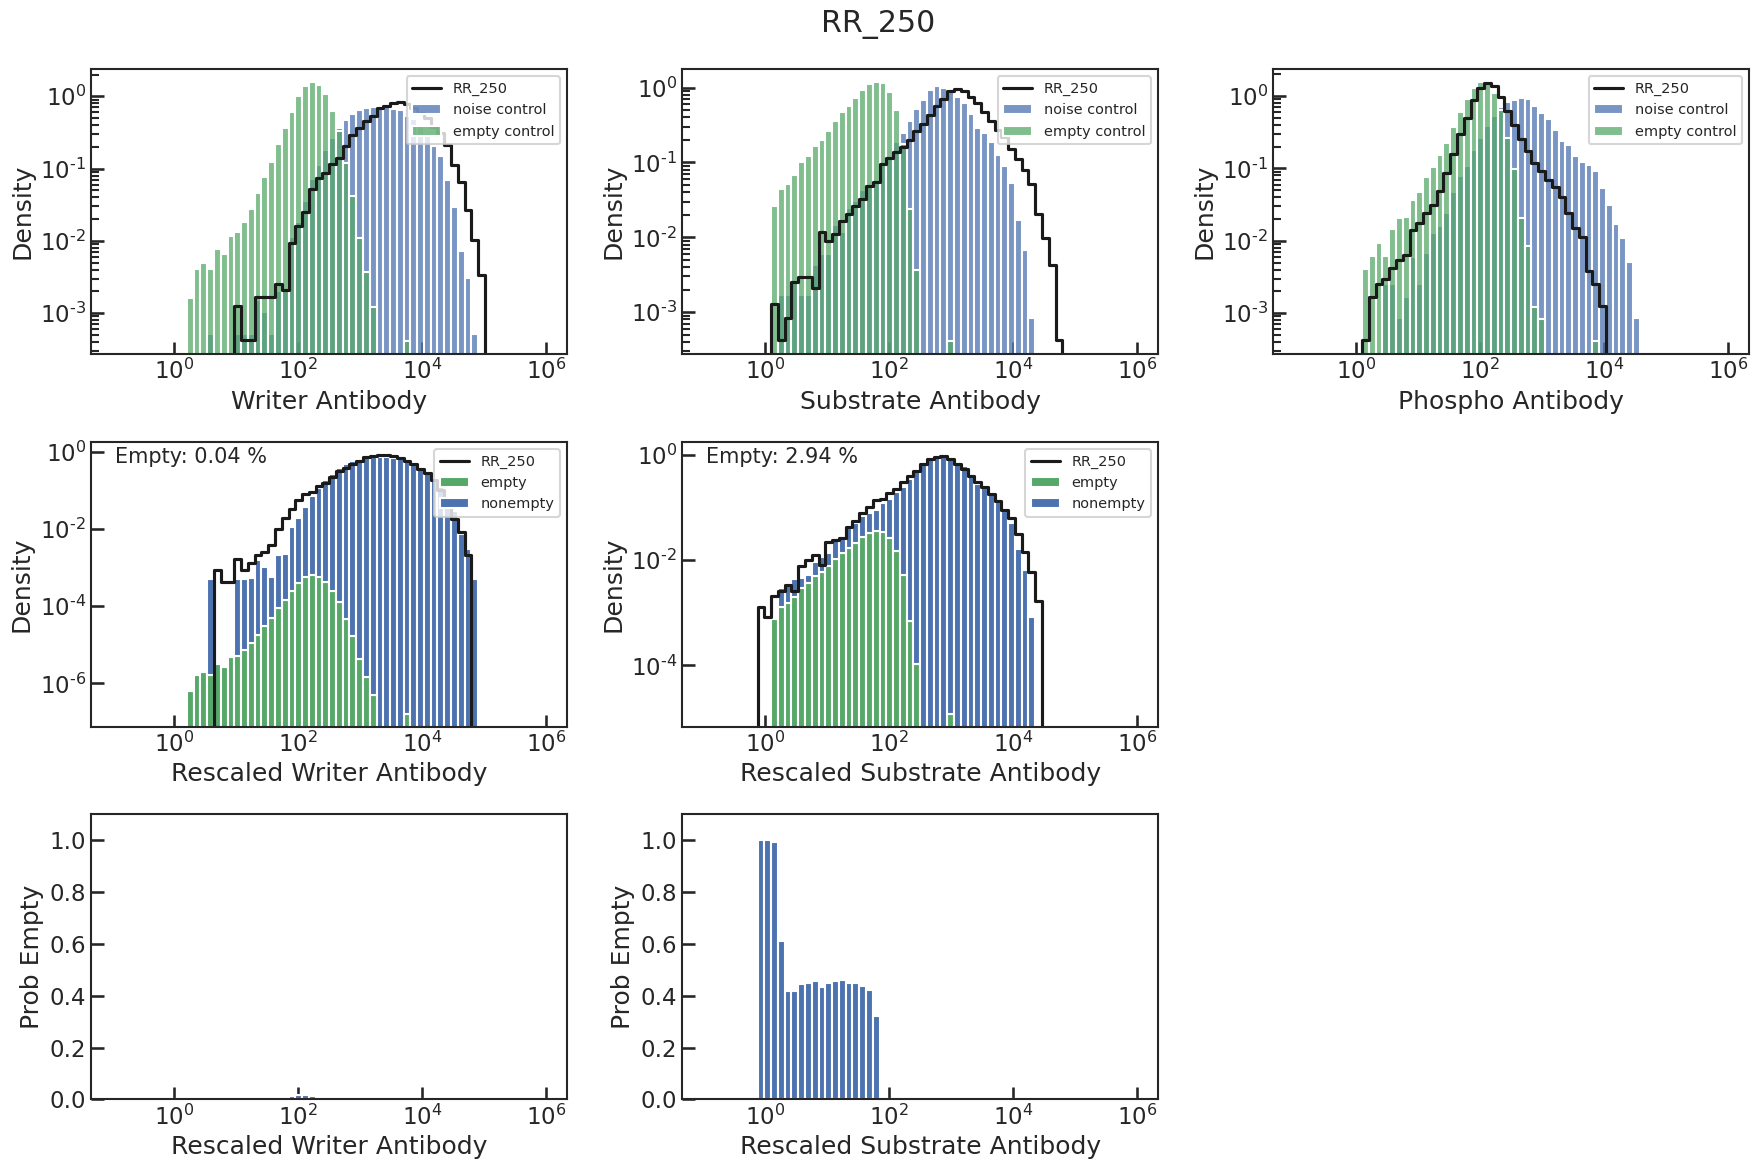

2 0.15917908034523032 [0.05424365 0.04424365] 0
4 0.1442059987884619 [0.03443946 0.04424365] 0
16 0.1383144992792416 [0.02592869 0.04424365] 0
19 0.09653222183839005 [0.010186   0.08780195] 0
31 0.07160292566452889 [0.07904836 0.23468898] 0
36 0.03681168782339439 [0.01336229 0.23468898] 0
44 0.0325502997889221 [0.02899006 0.23468898] 0
48 0.031018507890611002 [0.03463718 0.23468898] 0
180 0.029770171965796677 [0.03925096 0.23468898] 0
218 0.02872805266943998 [0.0281252  0.21417949] 0
240 0.024849833349341433 [0.01491677 0.21417949] 0
260 0.023553730456206234 [0.01965605 0.21417949] 0
321 0.02251204254551603 [0.01965605 0.2113701 ] 0
1444 0.022366133988203862 [0.01850781 0.2113701 ] 0
2486 0.021616423350227953 [0.00506759 0.20308915] 0
2492 0.020328879059572147 [0.01022626 0.20308915] 0
2560 0.020019557077469857 [0.01236577 0.20308915] 0
2660 0.019867578406792985 [0.01220621 0.20308915] 0
3358 0.01828320052549906 [0.00727087 0.19721904] 0
3757 0.018220399948981614 [0.00727087 0.19766307

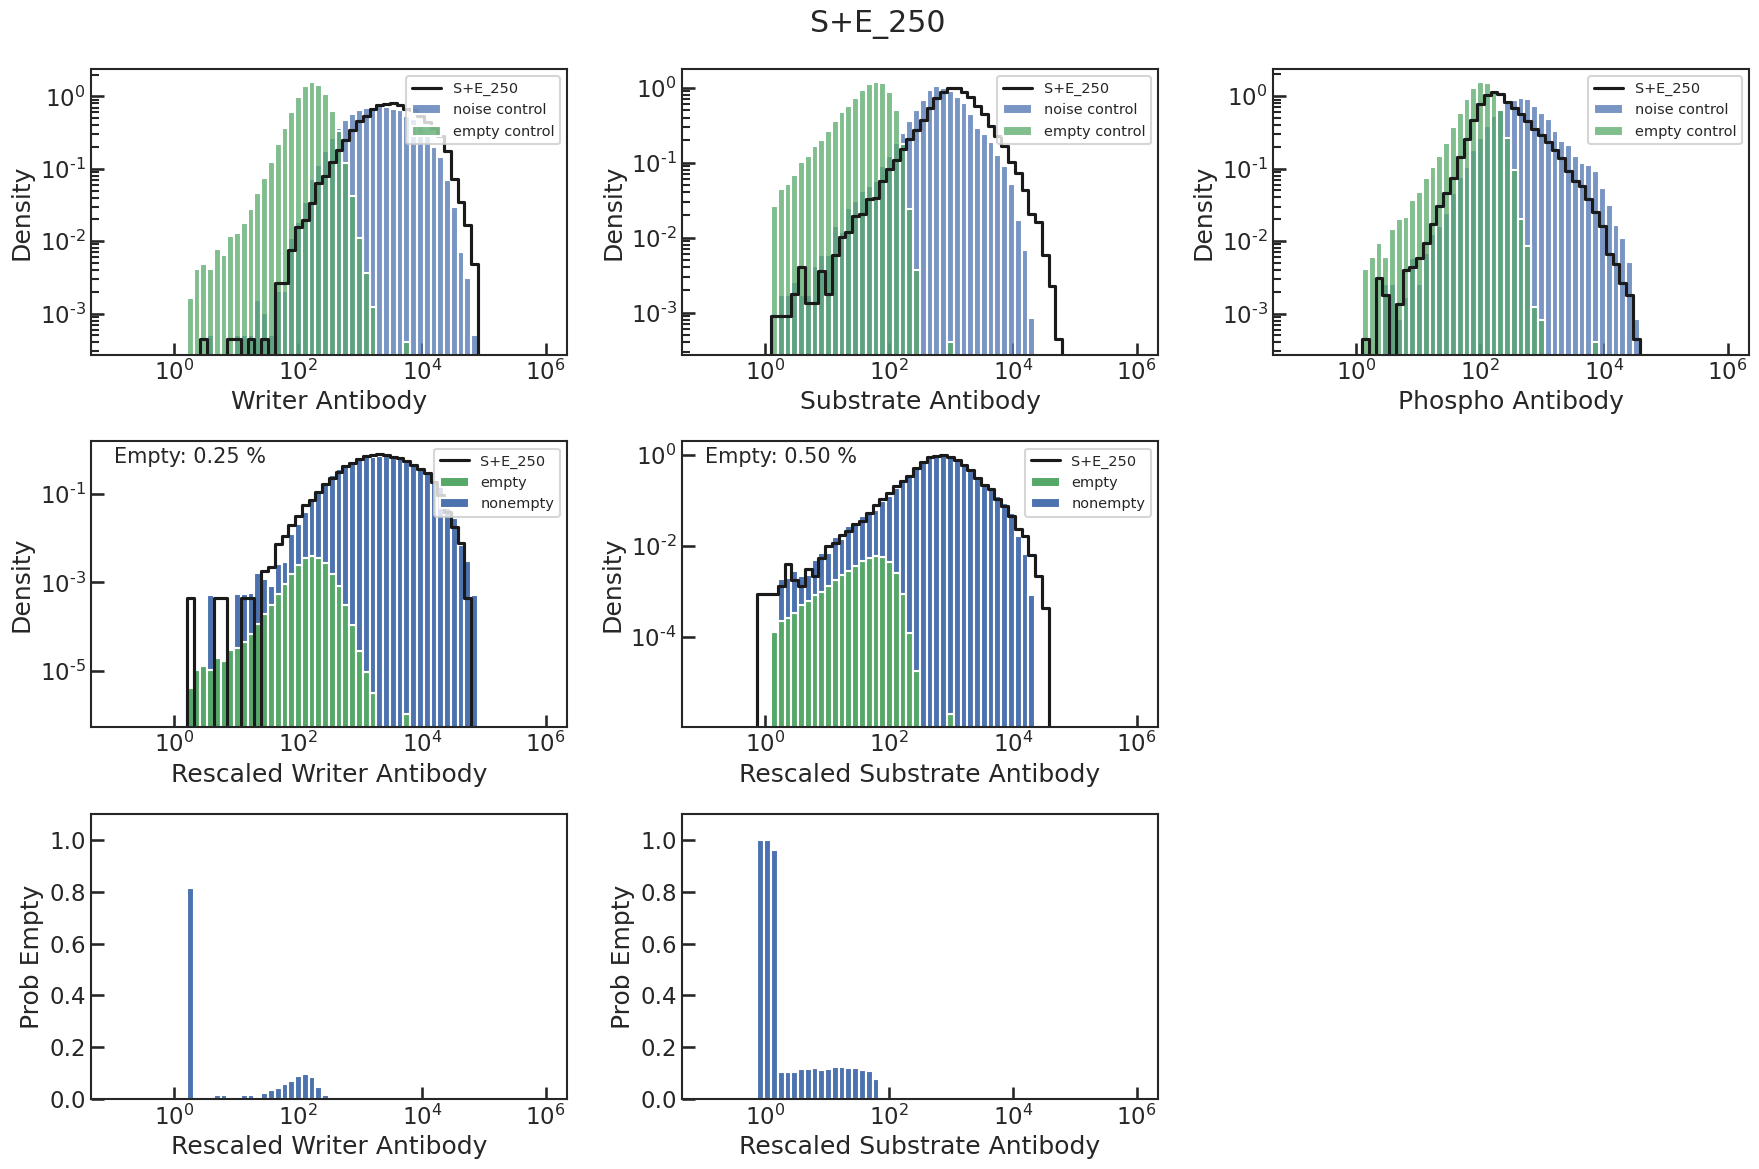

2 0.35676120603990696 [0.05424365 0.04424365] 0
4 0.34514290967508876 [0.03443946 0.04424365] 0
6 0.30588079489044895 [0.17064371 0.25609049] 0
11 0.18207691102903717 [0.20324843 0.62406757] 0
16 0.1738237591940815 [0.19473766 0.62406757] 0
19 0.14349648913426946 [0.17899497 0.66762587] 0
50 0.11945515674843277 [0.01796114 0.35277946] 0
68 0.10785248525608748 [0.00396683 0.35277946] 0
123 0.06852900924979347 [0.02342863 0.4455256 ] 0
132 0.06706074205279733 [0.0058024 0.4455256] 0
164 0.06657143432983248 [0.00783495 0.4455256 ] 0
182 0.0630454052693668 [0.00982624 0.43187559] 0
340 0.061490271143275765 [0.0082195  0.43187559] 0
388 0.06003082956423289 [0.00288773 0.43187559] 0
556 0.05934597199017322 [0.00572904 0.43187559] 0
688 0.059298055398172345 [0.00592799 0.43187559] 0
3358 0.05816008841003442 [0.00099264 0.42600548] 0
3397 0.058160088410034394 [0.00099264 0.42589163] 0
3405 0.05762969216241609 [0.00099264 0.42679285] 0
3661 0.05762969216241587 [0.00099264 0.42676505] 0
4226 0.0

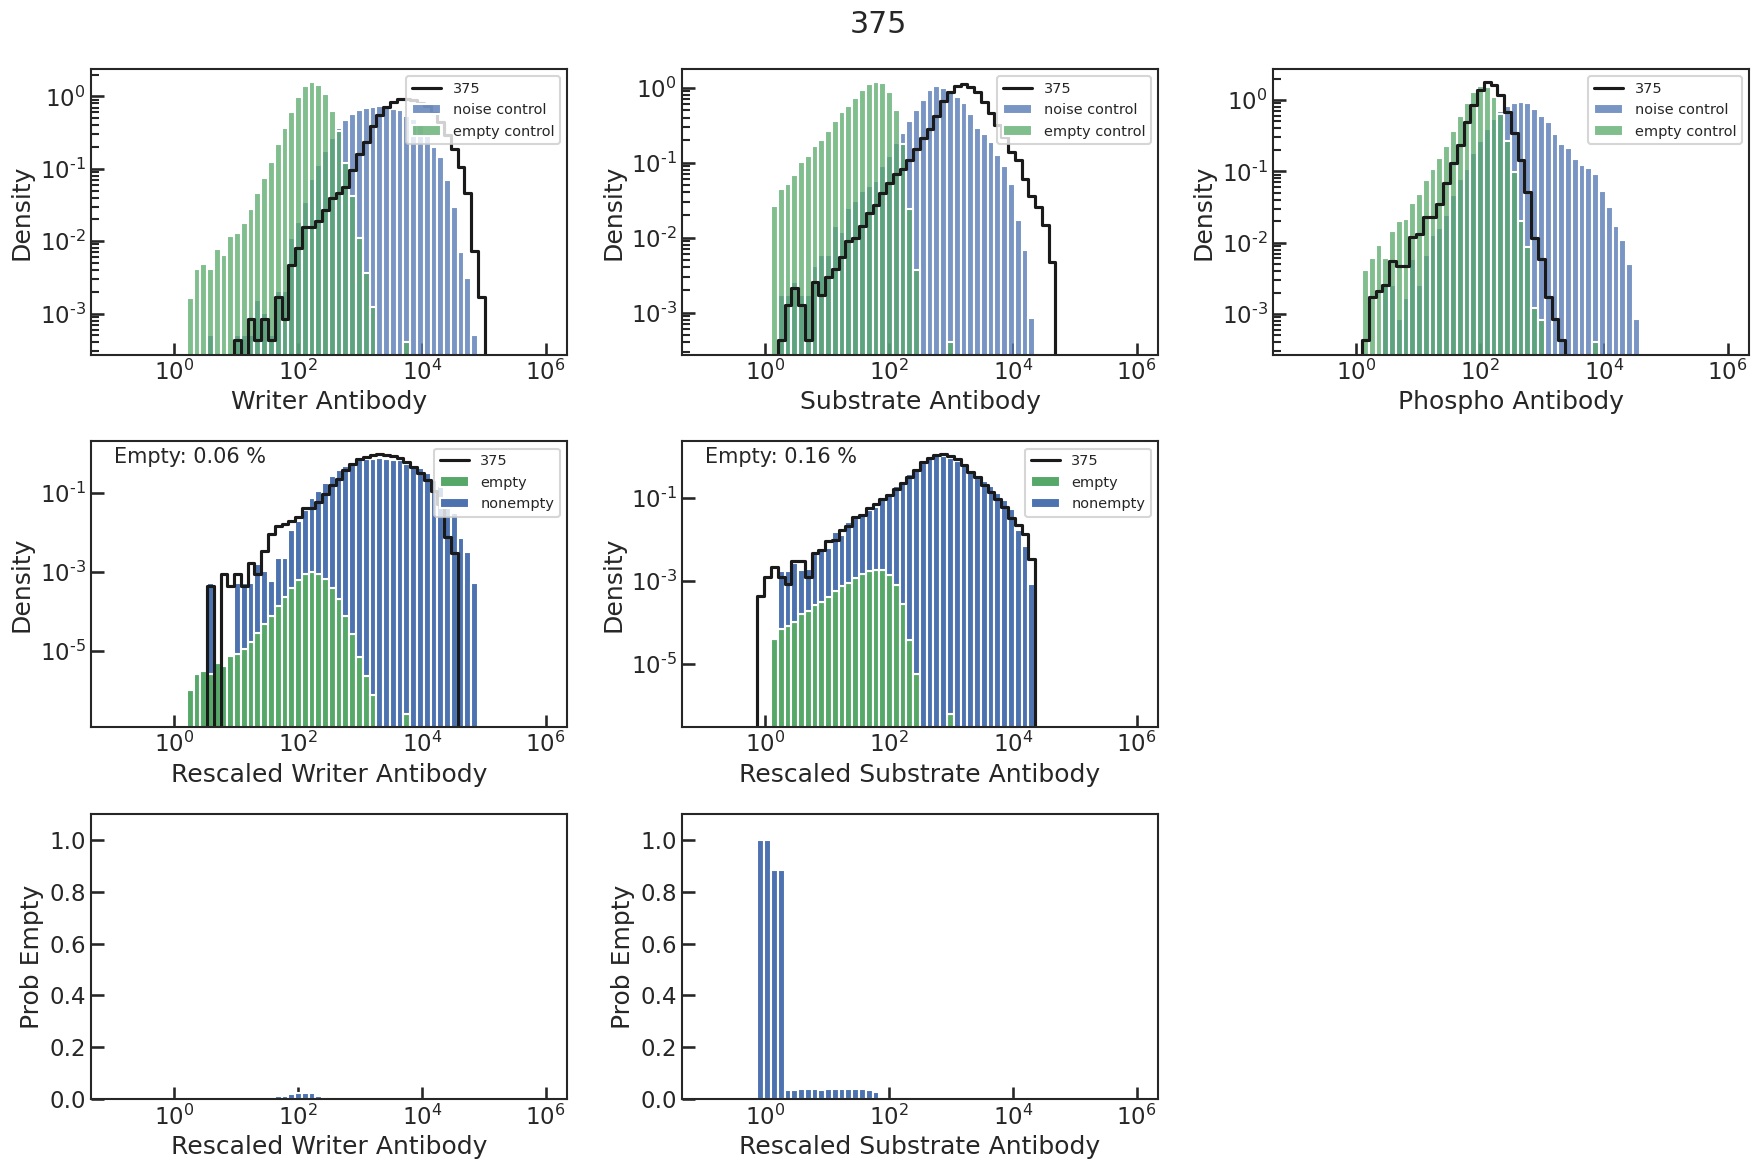

2 0.2358086225273759 [0.05424365 0.04424365] 0
4 0.22559392599803407 [0.03443946 0.04424365] 0
6 0.18059336214603658 [0.17064371 0.25609049] 0
11 0.1150954362175095 [0.20324843 0.62406757] 0
12 0.10923872052367961 [0.24088819 0.62406757] 0
14 0.0687355566128588 [0.06932197 0.45250135] 0
40 0.0658281388819304 [0.08165754 0.45250135] 0
52 0.06047625867920137 [0.10478717 0.45250135] 0
56 0.060349497621988824 [0.10535526 0.45250135] 0
220 0.05972775512592832 [0.10814394 0.45250135] 0
317 0.05838744965240672 [0.10814394 0.44969197] 0
444 0.05749324289410174 [0.11205114 0.44969197] 0
484 0.05659898273924013 [0.11611535 0.44969197] 0
498 0.0255760051784083 [0.00895841 0.31768439] 0
608 0.02449729565808667 [0.00691075 0.31768439] 0
1172 0.024010337215091382 [0.00598706 0.31768439] 0
2061 0.023957111125203503 [0.00598706 0.31849853] 0
2288 0.02367216464636515 [0.00630271 0.31849853] 0
2484 0.023584595279216858 [0.00649039 0.31849853] 0
2553 0.023583135847192446 [0.00649039 0.3193665 ] 0
2861 0.

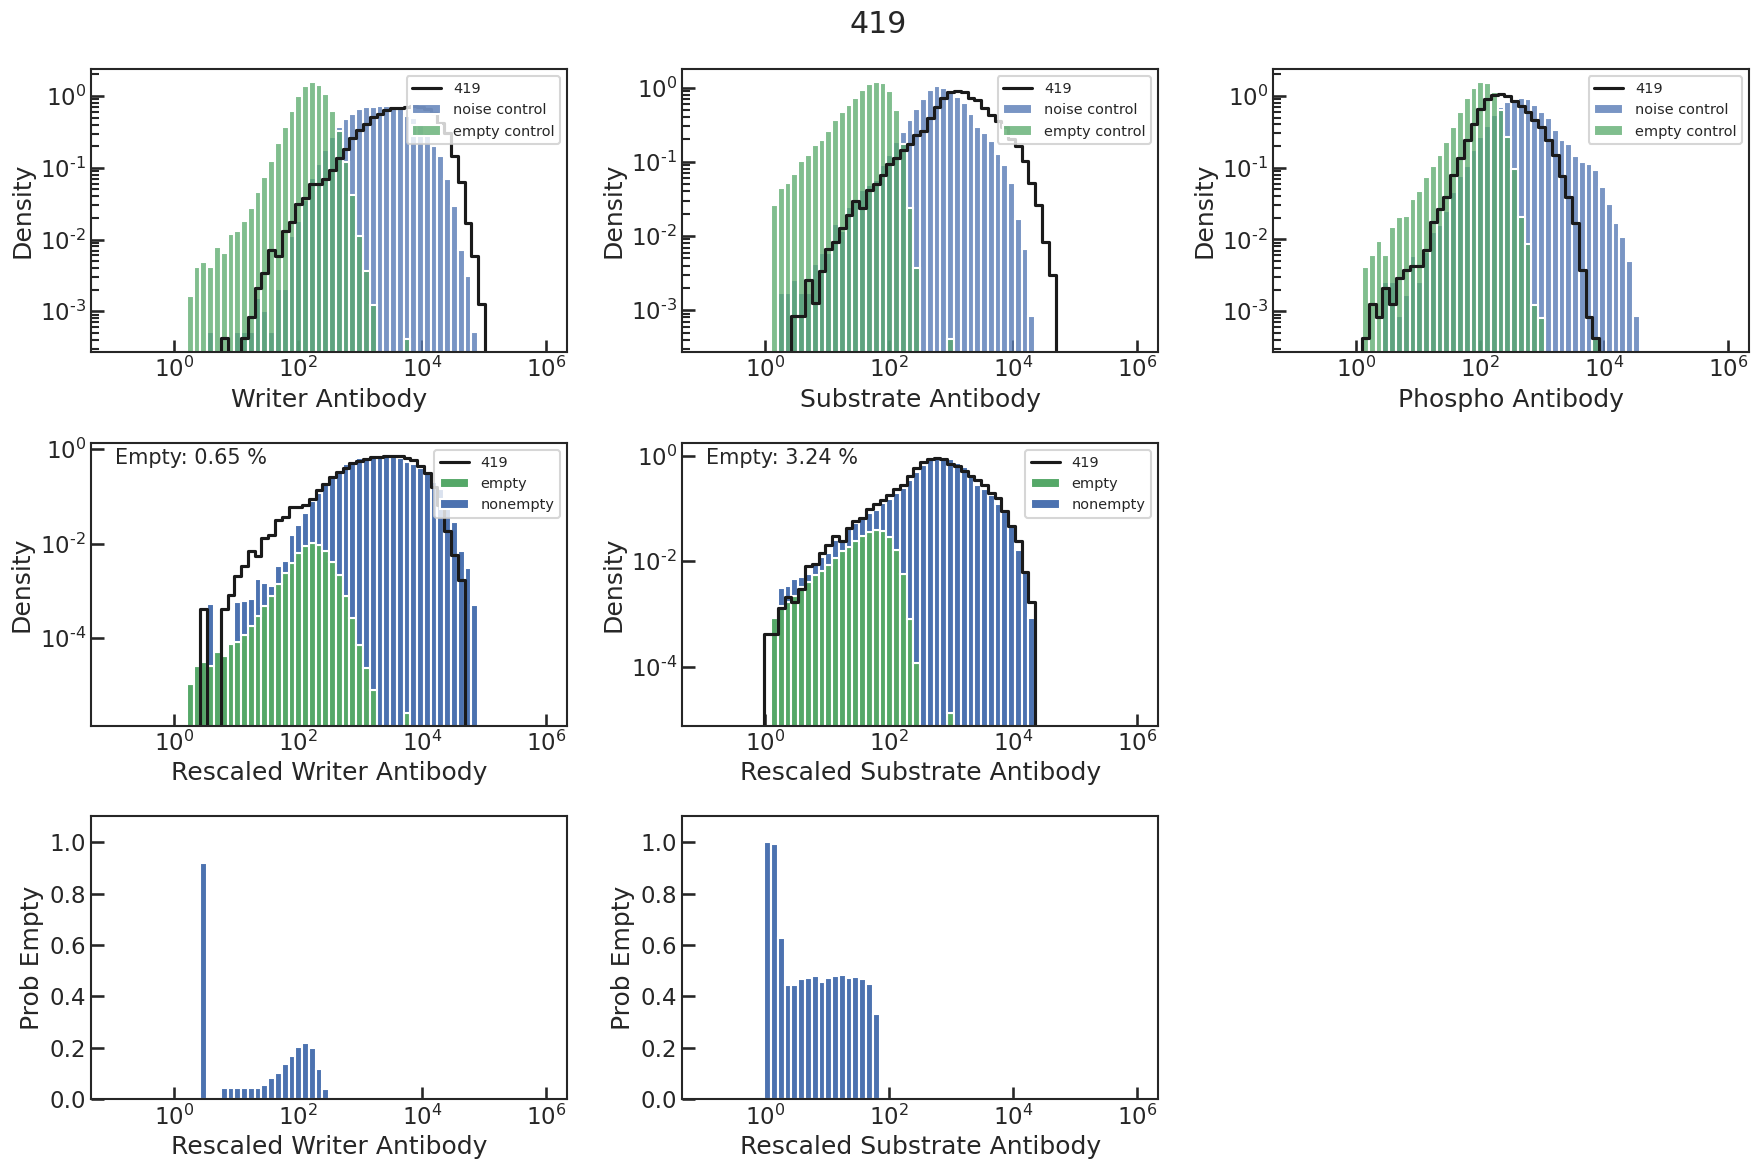

2 0.24841662336376402 [0.05424365 0.04424365] 0
4 0.23679843824970426 [0.03443946 0.04424365] 0
6 0.21494542562788554 [0.17064371 0.25609049] 0
11 0.1111821426910527 [0.20324843 0.62406757] 0
16 0.10504956879538252 [0.19473766 0.62406757] 0
82 0.0728817743612272 [0.05542932 0.32043051] 0
171 0.02840957345236239 [0.02697858 0.3730578 ] 0
240 0.02817773721280259 [0.02848777 0.3730578 ] 0
321 0.028097921372958426 [0.02848777 0.37024841] 0
367 0.025276088408326902 [0.00077649 0.31071311] 0
587 0.018990207557352312 [0.00122088 0.321496  ] 0
1357 0.01868335202893201 [0.00122088 0.34118992] 0
1489 0.014191588663783561 [0.00122088 0.33138212] 0
1636 0.014054518595195353 [0.00227136 0.33138212] 0
2489 0.013412589426912813 [0.00227136 0.32961908] 0
3016 0.013399314441908117 [0.00236398 0.32961908] 0
3253 0.013391992795215968 [0.00236398 0.32945598] 0
3416 0.013379572901106473 [0.00214187 0.32945598] 0
3457 0.013359880164157234 [0.00214187 0.32939702] 0
3653 0.013359880164156235 [0.00214187 0.329

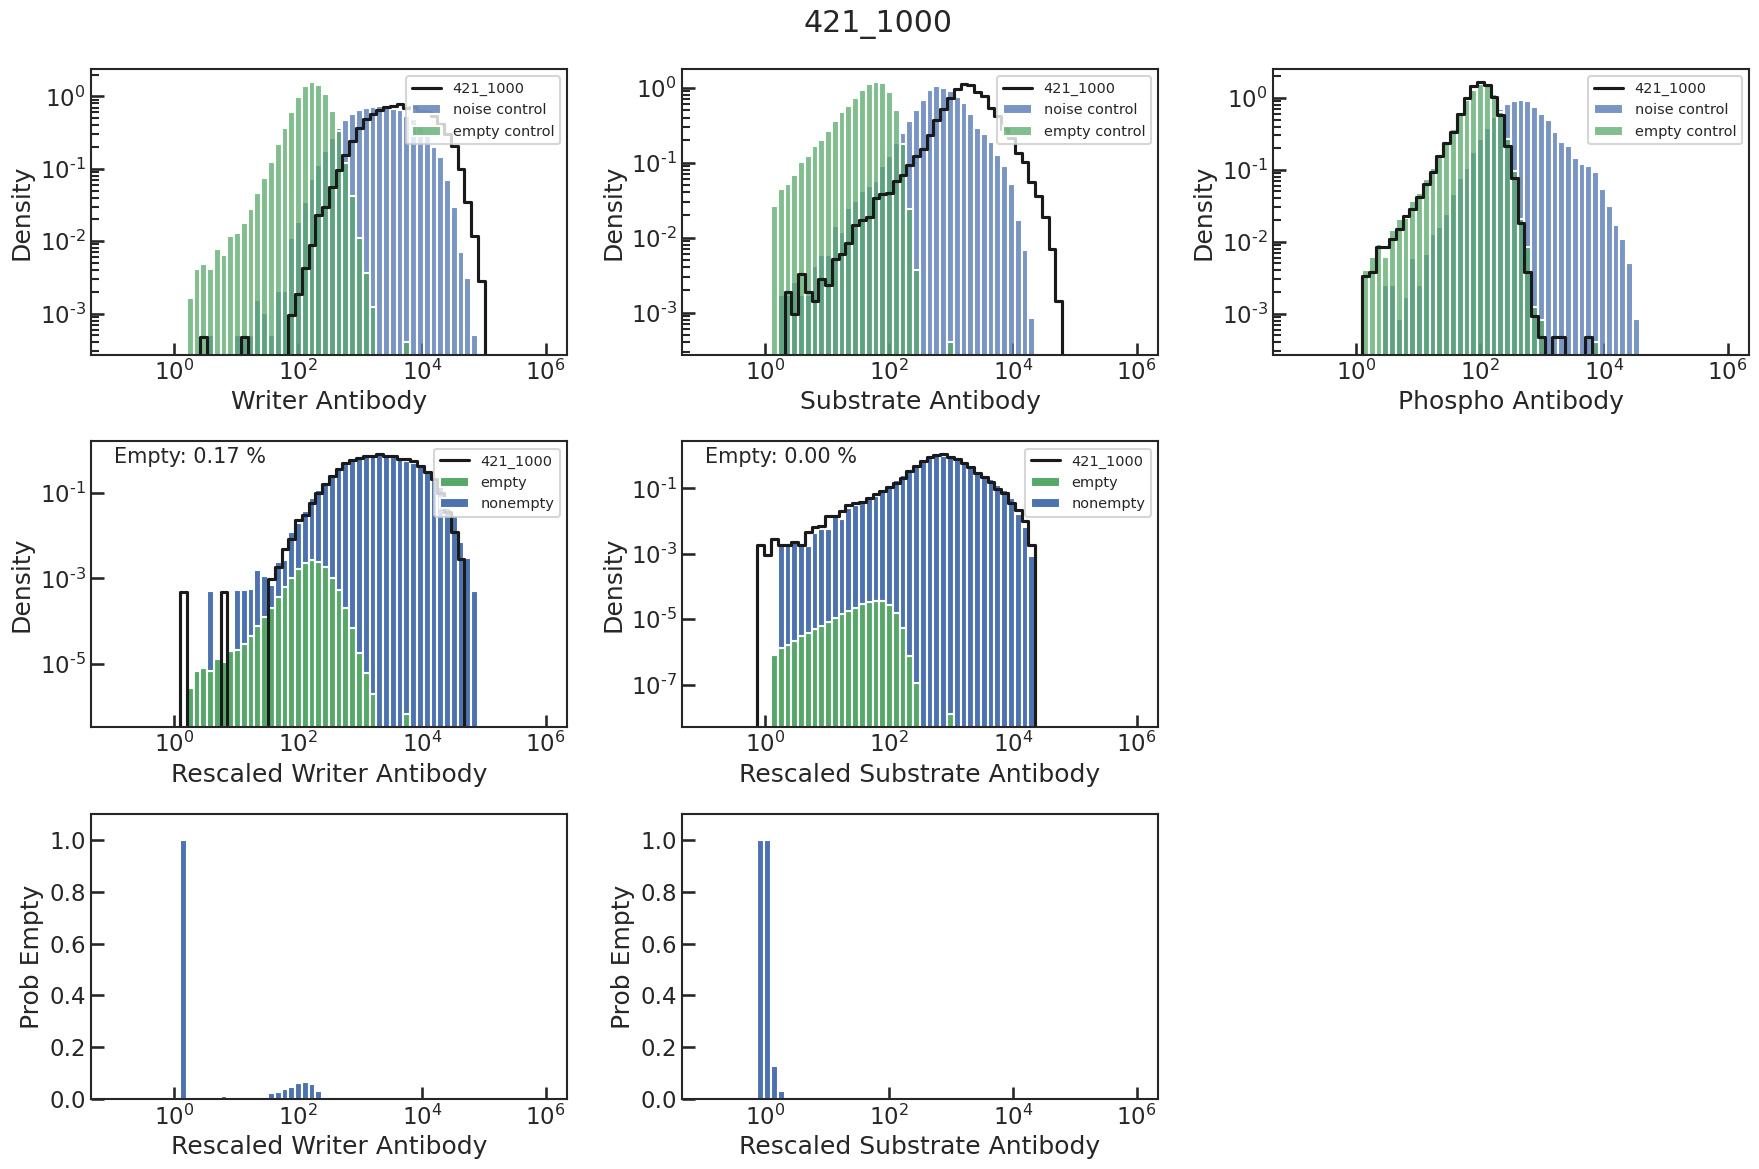

dataset   zipper kinase model  WT_empty_frac  WT_anti_scale  \
0     L_250     EE_L     wt  push       0.001320       0.336913   
1     E_250     EE_E     wt  push       0.003690       0.278620   
2    RR_250       RR     wt  push       0.000399       0.248533   
3   S+E_250      S+E     wt  push       0.002518       0.192824   
4       375  generic    375  push       0.000621       0.426397   
5       419  generic    419  push       0.006490       0.318600   
6  421_1000  generic    421  push       0.001675       0.328734   

   ST_empty_frac  ST_anti_scale  
0       0.003508       0.388868  
1       0.026181       0.273877  
2       0.029363       0.282584  
3       0.004982       0.207894  
4       0.001565       0.348545  
5       0.032397       0.346711  
6       0.000031       0.411817

In [33]:
binrange = (-1, 6)

for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.query("dataset==@dataset").copy()
    
    fig = plt.figure(figsize=(18, 12))
    
    fig.suptitle(dataset)
    
    ax = fig.add_subplot(3, 3, 1)
    
    sns.histplot(df_tmp['WT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(writer_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_writer_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')
        
    ax.set_xlabel("Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    ################################################################
    
    
    (writer_empty_frac, writer_anti_scale) = noise.calc_mixture(df_tmp['WT_anti_exp'], 
                                                                empty_writer_noise, writer_noise)

    
    df_info.loc[index, 'WT_empty_frac'] = writer_empty_frac
    df_info.loc[index, 'WT_anti_scale'] = writer_anti_scale
    
        
    df.loc[df_tmp.index, 'WT_anti_rescaled'] = df_tmp['WT_anti_exp'] / 10**writer_anti_scale
        
        
    ax = fig.add_subplot(3, 3, 4, sharex=ax)
            
    
    
    sns.histplot(df.loc[df_tmp.index, 'WT_anti_rescaled'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    
    
    nonempty_hist, edges = np.histogram(np.log10(writer_noise.get_anti()), range=binrange, bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_writer_noise.get_anti()), range=binrange, bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([10**edges[:-1], 10**edges[:-1]], 10**edges, 
            weights=[empty_hist/empty_norm*writer_empty_frac, nonempty_hist/nonempty_norm*(1-writer_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
    
        
    ax.set_xlabel("Rescaled Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    ax.text(0.05, 0.98, "Empty: {0:.2f} %".format(100*writer_empty_frac), transform=ax.transAxes,
           va='top', ha='left', fontsize='small')
    
    
    
    ################################################################
    
    df.loc[df_tmp.index, 'WT_prob_empty'] = noise.calc_prob_empty(df.loc[df_tmp.index, 'WT_anti_rescaled'], 
                                                                 writer_empty_frac, 
                                                                 empty_writer_noise, writer_noise)
    
    ax = fig.add_subplot(3, 3, 7, sharex=ax)
    
    df_tmp = df_tmp.copy()
    df_tmp['bin'] = pd.cut(df.loc[df_tmp.index, 'WT_anti_rescaled'], 10**edges, labels=False)
    df_tmp['prob_empty'] = df.loc[df_tmp.index, 'WT_prob_empty']    
    
    hist_corr = df_tmp.groupby(['bin'])['prob_empty'].mean().to_frame("mean")
    
    hist_corr =  hist_corr.reindex(pd.Index(np.arange(len(edges)-1), name='bin', fill_value=np.nan))['mean'].values
    hist_corr = np.nan_to_num(hist_corr)

    ax.hist(10**edges[:-1], 10**edges, weights=hist_corr, histtype='bar', color='b')
    
    ax.set_ylim(0, 1.1)
    
    ax.set_xlabel("Rescaled Writer Antibody")
    ax.set_ylabel("Prob Empty")
    
    
    ################################################################
    
    
    
    ax = fig.add_subplot(3, 3, 2)
        
    sns.histplot(df_tmp['ST_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(substrate_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_substrate_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    
    ################################################################
    
    (substrate_empty_frac, substrate_anti_scale) = noise.calc_mixture(df_tmp['ST_anti_exp'], 
                                                                empty_substrate_noise, substrate_noise)

        
    df_info.loc[index, 'ST_empty_frac'] = substrate_empty_frac
    df_info.loc[index, 'ST_anti_scale'] = substrate_anti_scale
        
    ax = fig.add_subplot(3, 3, 5, sharex=ax)
            
    df.loc[df_tmp.index, 'ST_anti_rescaled'] = df_tmp['ST_anti_exp'] / 10**substrate_anti_scale
    
    sns.histplot(df.loc[df_tmp.index, 'ST_anti_rescaled'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    
    
    nonempty_hist, edges = np.histogram(np.log10(substrate_noise.get_anti()), range=binrange, bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_substrate_noise.get_anti()), range=binrange, bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([10**edges[:-1], 10**edges[:-1]], 10**edges, 
            weights=[empty_hist/empty_norm*substrate_empty_frac, nonempty_hist/nonempty_norm*(1-substrate_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
    
        
    ax.set_xlabel("Rescaled Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
      
    ax.text(0.05, 0.98, "Empty: {0:.2f} %".format(100*substrate_empty_frac), transform=ax.transAxes,
           va='top', ha='left', fontsize='small')
    
    
    ################################################################
    
    df.loc[df_tmp.index, 'ST_prob_empty'] = noise.calc_prob_empty(df.loc[df_tmp.index, 'ST_anti_rescaled'], 
                                                                 substrate_empty_frac, 
                                                                 empty_substrate_noise, substrate_noise)
    
    ax = fig.add_subplot(3, 3, 8, sharex=ax)
    
    df_tmp['bin'] = pd.cut(df.loc[df_tmp.index, 'ST_anti_rescaled'], 10**edges, labels=False)
    df_tmp['prob_empty'] = df.loc[df_tmp.index, 'ST_prob_empty']    
    
    hist_corr = df_tmp.groupby(['bin'])['prob_empty'].mean().to_frame("mean")
    
    hist_corr =  hist_corr.reindex(pd.Index(np.arange(len(edges)-1), name='bin', fill_value=np.nan))['mean'].values
    hist_corr = np.nan_to_num(hist_corr)

    ax.hist(10**edges[:-1], 10**edges, weights=hist_corr, histtype='bar', color='b')
    
    ax.set_ylim(0, 1.1)
    
    ax.set_xlabel("Rescaled Substrate Antibody")
    ax.set_ylabel("Prob Empty")
    
    
    ################################################################
    
    ax = fig.add_subplot(3, 3, 3)
    
    sns.histplot(df_tmp['SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()
    
display(df_info)


In [34]:

zero = 0.0

for dataset, group in df.groupby("dataset"): 
    
    # convert antibody measurements to GFP measurements
    GFP_infer, anti_bin, GFP_bin = writer_noise.anti_to_GFP(df.loc[group.index, 'WT_anti_rescaled'])
    df.loc[group.index, 'WT_GFP_infer'] = GFP_infer
#     df.loc[group.index, 'WT_anti_bin'] = anti_bin
#     df.loc[group.index, 'WT_GFP_bin'] = GFP_bin
    df.loc[group.index, 'WT_conc_infer'] = np.maximum(df.loc[group.index, 'WT_GFP_infer'] - np.median(empty_writer_noise.get_GFP()), zero)

    GFP_infer, anti_bin, GFP_bin = substrate_noise.anti_to_GFP(df.loc[group.index, 'ST_anti_rescaled'])
    df.loc[group.index, 'ST_GFP_infer'] = GFP_infer
#     df.loc[group.index, 'ST_anti_bin'] = anti_bin
#     df.loc[group.index, 'ST_GFP_bin'] = GFP_bin
    df.loc[group.index, 'ST_conc_infer'] = np.maximum(df.loc[group.index, 'ST_GFP_infer'] - np.median(empty_substrate_noise.get_GFP()), zero)

    
    GFP_infer, anti_bin, GFP_bin = combined_phospho_noise.anti_to_GFP(df.loc[group.index, 'SpT_anti_exp'])
    df.loc[group.index, 'SpT_GFP_infer'] = GFP_infer
#     df.loc[group.index, 'SpT_anti_bin'] = anti_bin
#     df.loc[group.index, 'SpT_GFP_bin'] = GFP_bin
    df.loc[group.index, 'SpT_conc_infer'] = np.maximum(df.loc[group.index, 'SpT_GFP_infer'] - np.median(empty_phospho_noise.get_GFP()), zero)

    df.loc[group.index, 'Sp_frac_GFP_infer'] = df.loc[group.index, 'SpT_GFP_infer'] / df.loc[group.index, 'ST_GFP_infer']
    df.loc[group.index, 'Sp_frac_conc_infer'] = df.loc[group.index, 'SpT_conc_infer'] / df.loc[group.index, 'ST_conc_infer']
    
    
    df.loc[group.index, 'total_prob_empty'] = 1.0  - (1-df.loc[group.index, 'ST_prob_empty'])*(1-df.loc[group.index, 'WT_prob_empty'])
    
    
print(len(df))
print(len(df.dropna()))


144282
143731


WT_anti_exp           float64
ST_anti_exp           float64
SpT_anti_exp          float64
Sp_frac_anti_exp      float64
WT_anti_rescaled      float64
WT_prob_empty         float64
ST_anti_rescaled      float64
ST_prob_empty         float64
WT_GFP_infer          float64
WT_conc_infer         float64
ST_GFP_infer          float64
ST_conc_infer         float64
SpT_GFP_infer         float64
SpT_conc_infer        float64
Sp_frac_GFP_infer     float64
Sp_frac_conc_infer    float64
total_prob_empty      float64
dtype: object

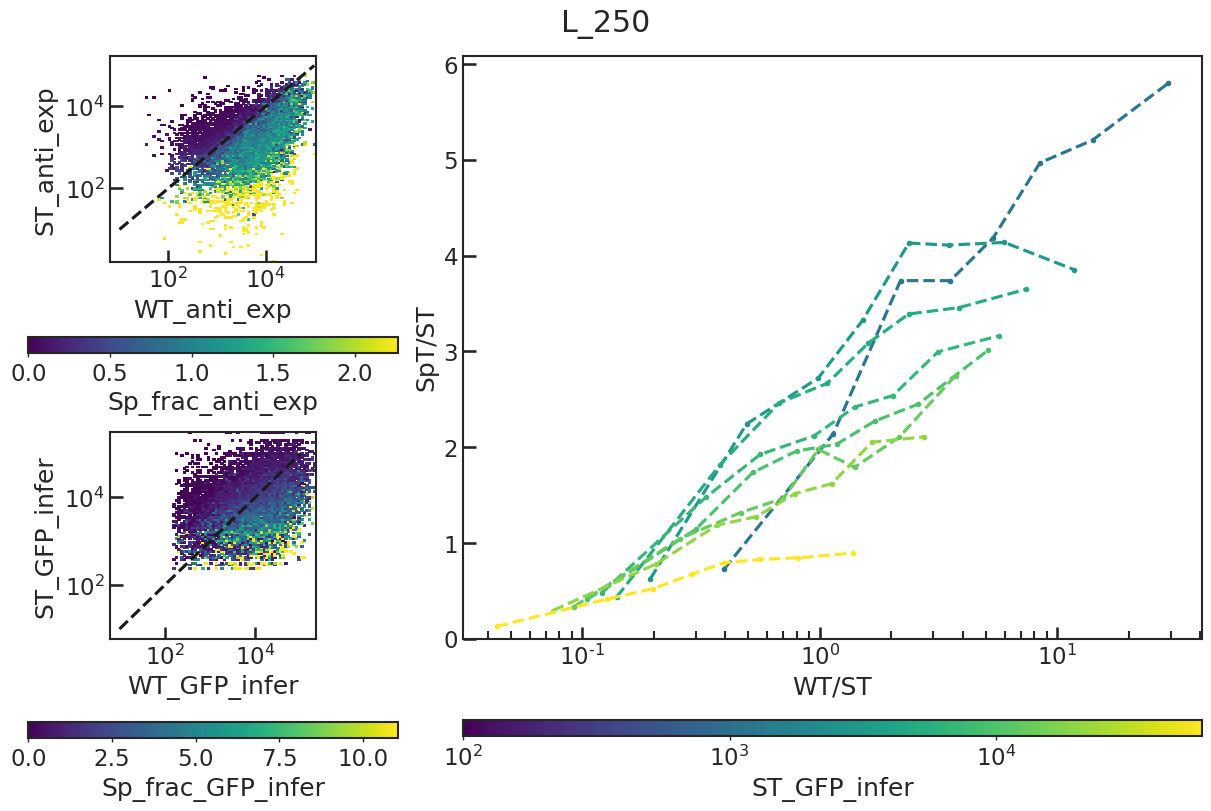

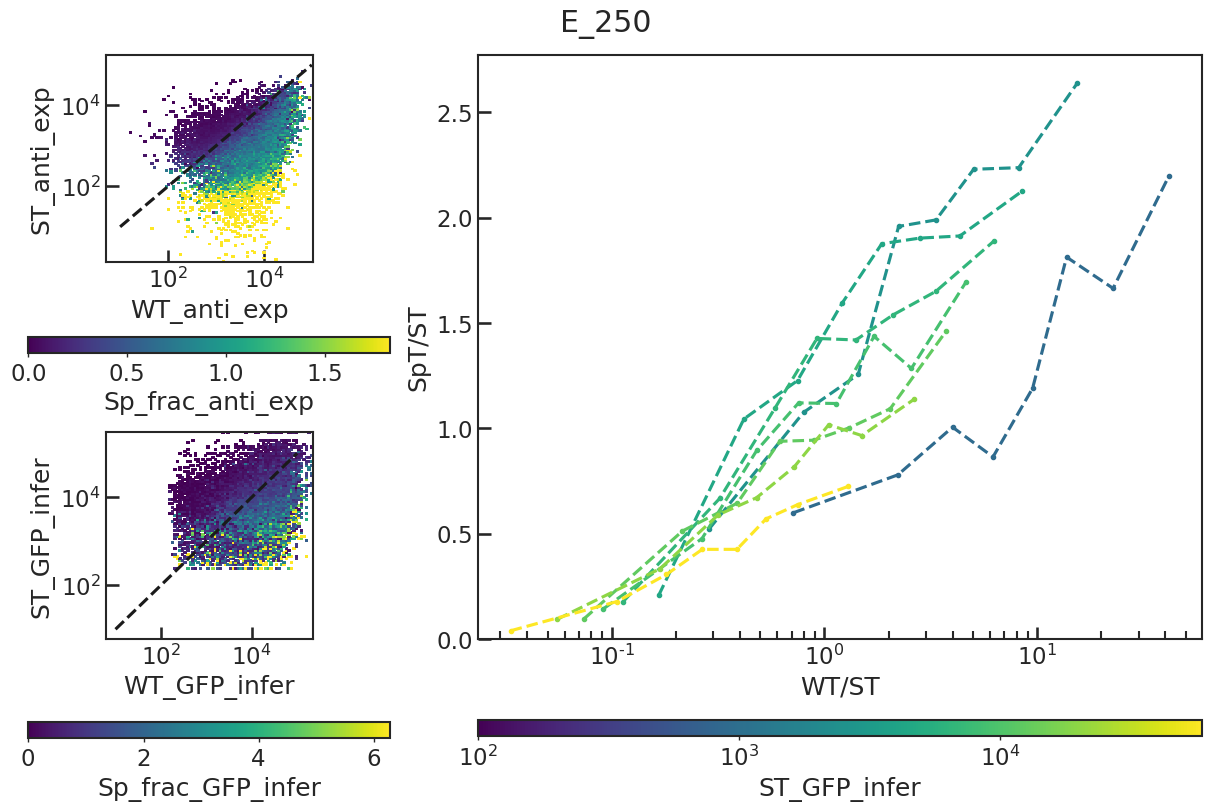

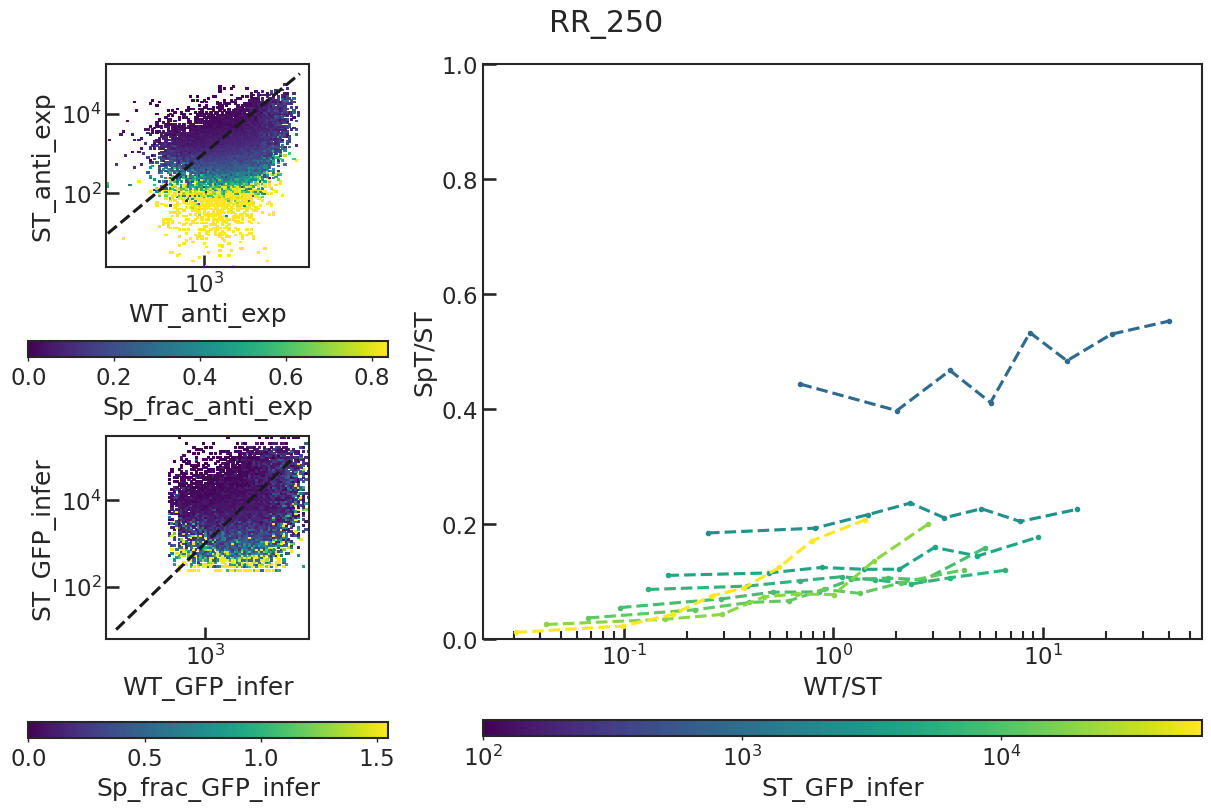

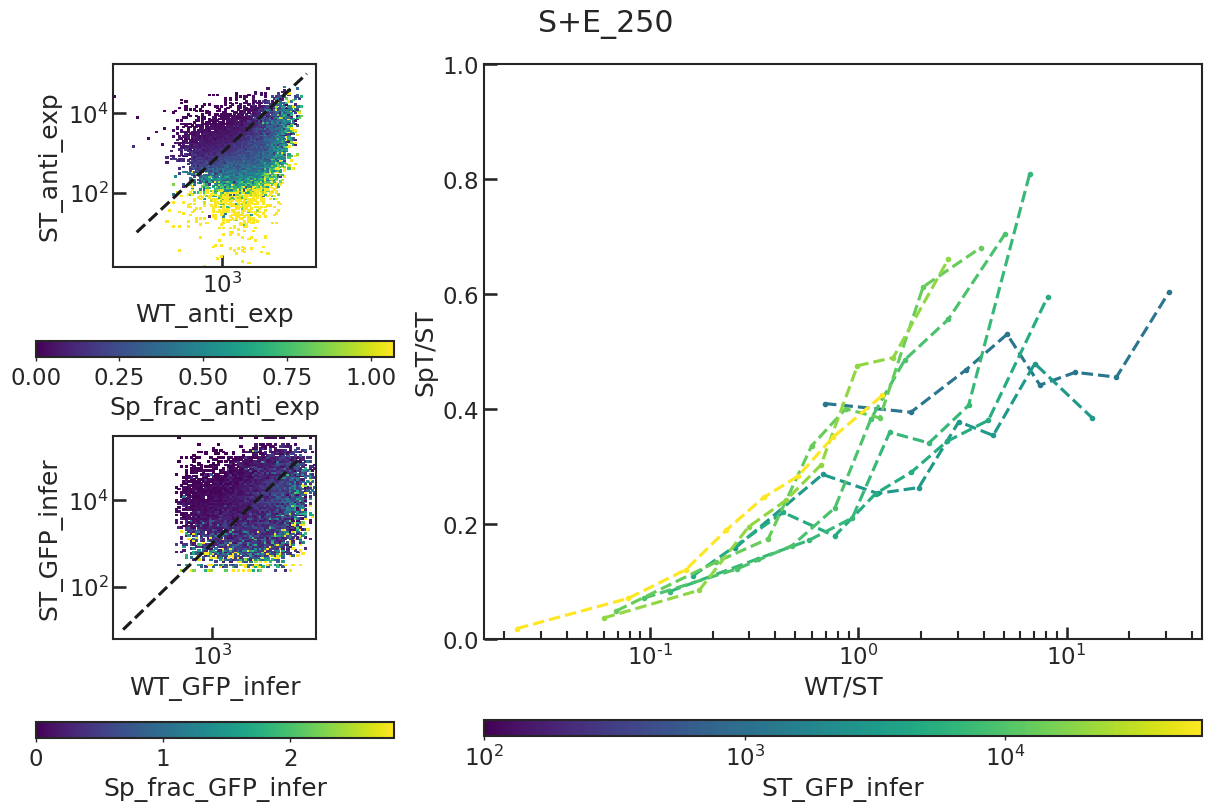

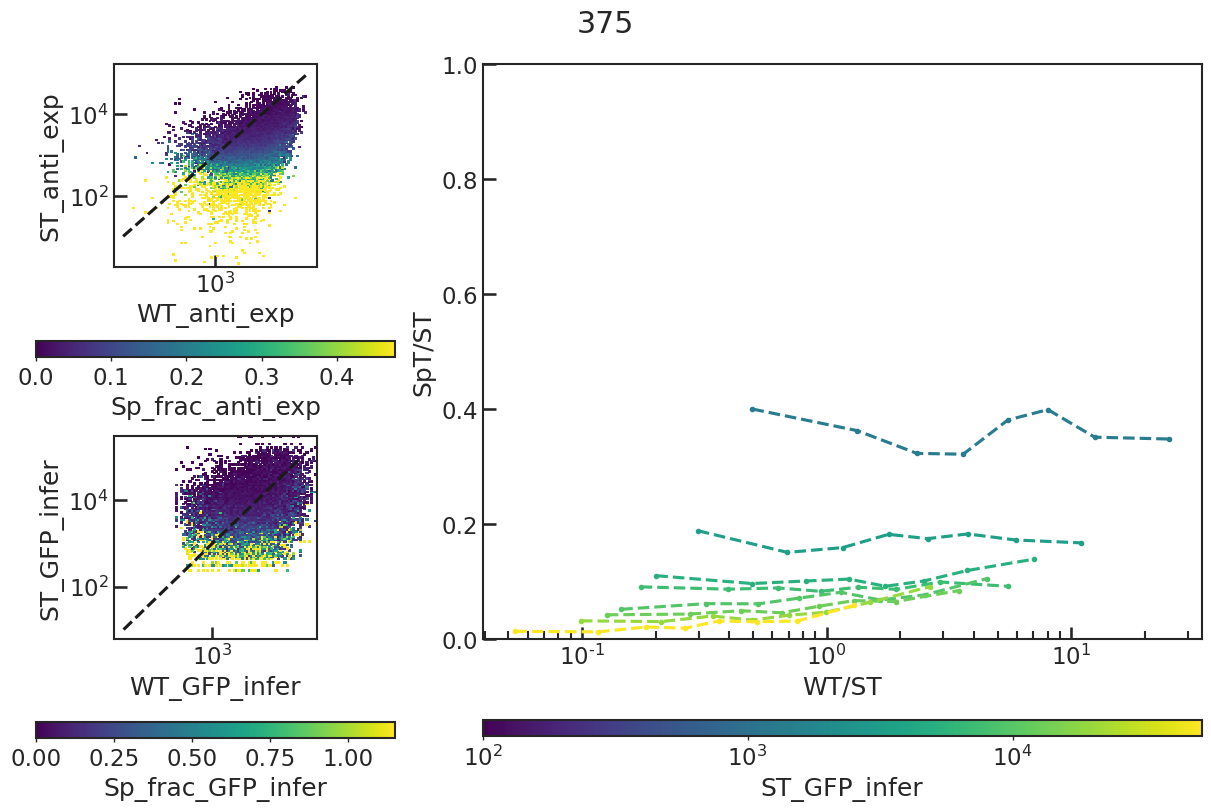

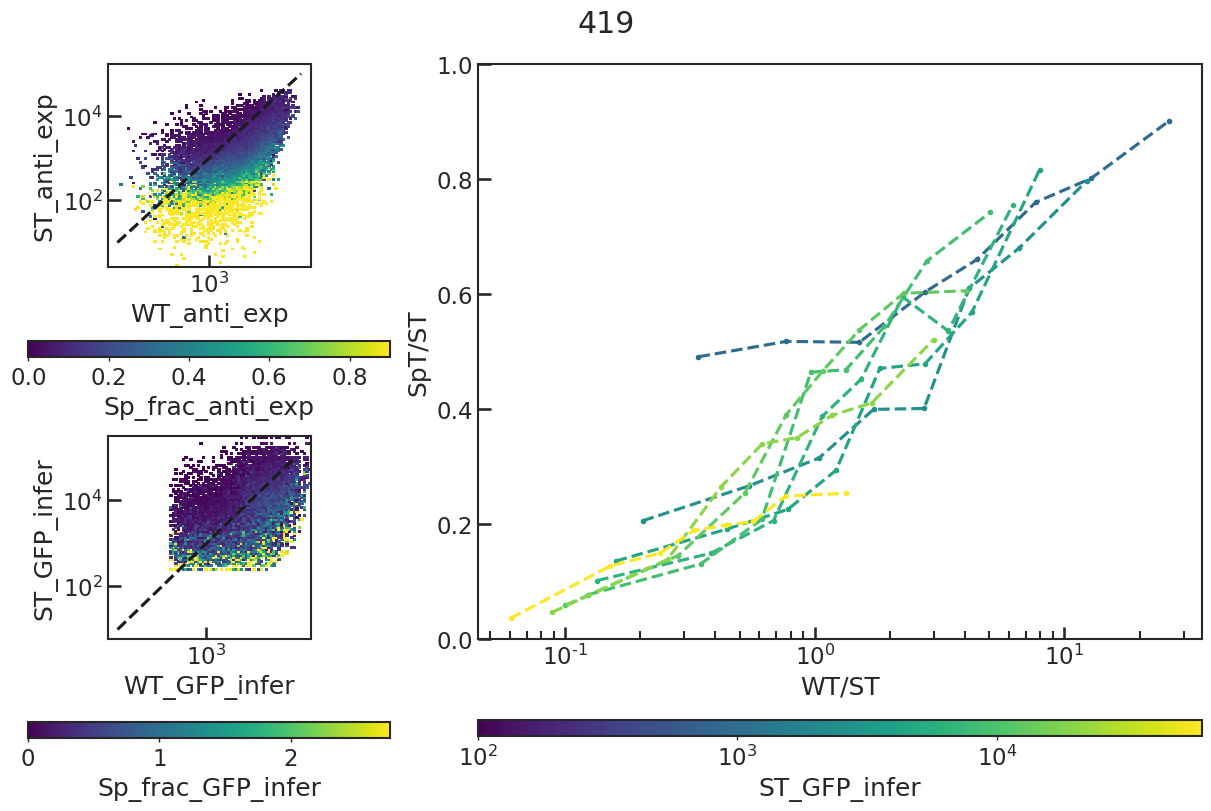

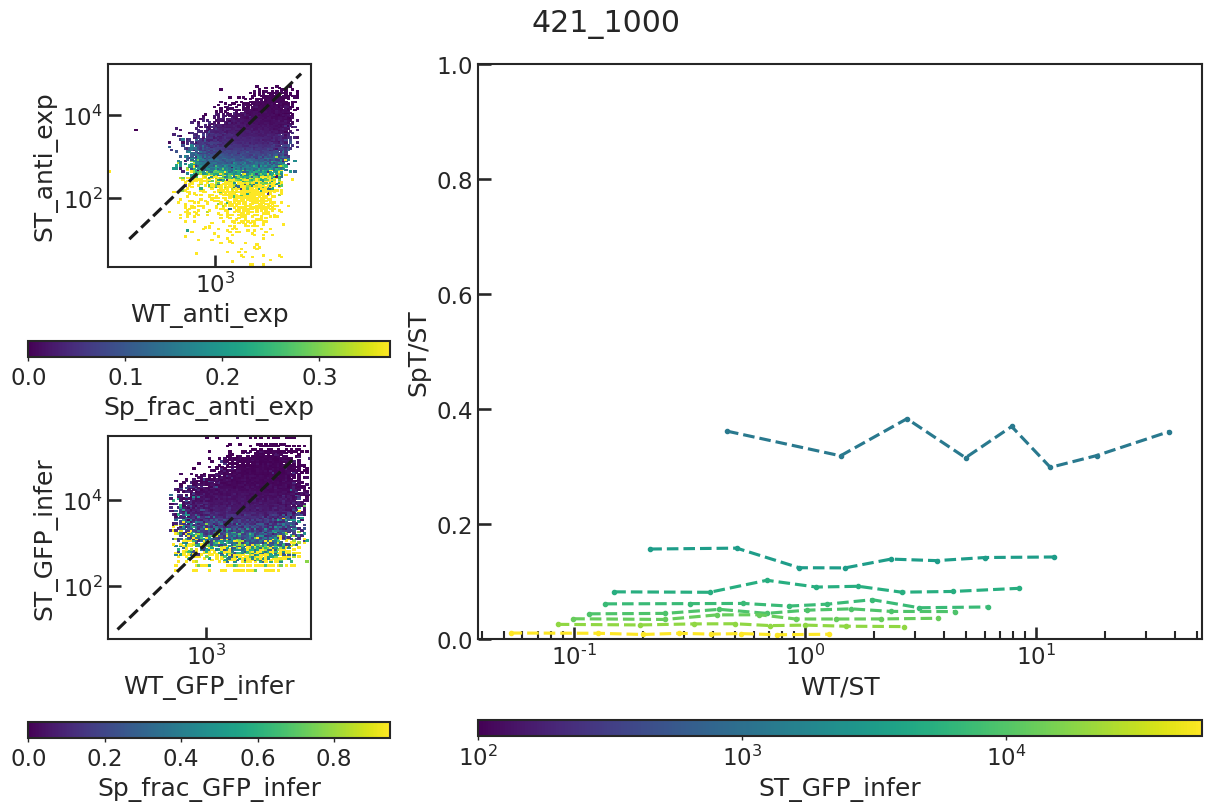

In [35]:



for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.query("dataset==@dataset").copy()    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    
    gs = fig.add_gridspec(2, 3)
    
    ##########################################################

    ax = fig.add_subplot(gs[0, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_anti_exp', 'ST_anti_exp', 'Sp_frac_anti_exp')

    ##########################################################   
    
    ax = fig.add_subplot(gs[1, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_GFP_infer', 'ST_GFP_infer', 'Sp_frac_GFP_infer')

    
    ##########################################################
    
    ax = fig.add_subplot(gs[:, 1:3])
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 
                                 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_infer')

    
    ##########################################################

    fig.suptitle(dataset)

    plt.show()
    

In [36]:
res, param_dict, param_labels = fit.fit_push(df_info, df, empty_phospho_noise)

['$\\log_{10}(v_{bg}^p)$', 'wt: $\\log_{10}(v_{WS}^p)$', 'EE_L: $\\log_{10}(\\alpha_{WS})$', 'EE_E: $\\log_{10}(\\alpha_{WS})$', 'RR: $\\log_{10}(\\alpha_{WS})$', 'S+E: $\\log_{10}(\\alpha_{WS})$', '375: $\\log_{10}(v_{WS}^p)$', 'generic: $\\log_{10}(\\alpha_{WS})$', '419: $\\log_{10}(v_{WS}^p)$', '421: $\\log_{10}(v_{WS}^p)$']
{'L_250': [0, 1, 2], 'E_250': [0, 1, 3], 'RR_250': [0, 1, 4], 'S+E_250': [0, 1, 5], '375': [0, 6, 7], '419': [0, 8, 7], '421_1000': [0, 9, 7]}
[-2.0, 0.0, 4.0, 4.0, 4.0, 4.0, 0.0, 4.0, 0.0, 0.0]
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
Initial Loss: 3.754849949130052
3.018378798656702 1.0201000000000015e-06 [-2.00885263  0.55492245  3.76563181  3.86621627  4.10598982  4.00749251
 -0.43113407  4.33913231 -0.02269426 -0.57145765]
2.7098527430837316 3.0735929052739017e-06 [-2.10230085  0.34973975  3.55820111  3.77182231  4.37588231  4.11727215
 -0.84691188  4.6809177

dataset   zipper kinase model  WT_empty_frac  WT_anti_scale  \
0     L_250     EE_L     wt  push       0.001320       0.336913   
1     E_250     EE_E     wt  push       0.003690       0.278620   
2    RR_250       RR     wt  push       0.000399       0.248533   
3   S+E_250      S+E     wt  push       0.002518       0.192824   
4       375  generic    375  push       0.000621       0.426397   
5       419  generic    419  push       0.006490       0.318600   
6  421_1000  generic    421  push       0.001675       0.328734   

   ST_empty_frac  ST_anti_scale  bg_phospho_rate  kinase_phospho_rate  \
0       0.003508       0.388868          0.00748            11.726074   
1       0.026181       0.273877          0.00748            11.726074   
2       0.029363       0.282584          0.00748            11.726074   
3       0.004982       0.207894          0.00748            11.726074   
4       0.001565       0.348545          0.00748             0.048100   
5       0.032397       0.346711          0.00748             0.550308   
6       0.000031       0.411817          0.00748             0.000014   

   kinase_bind_affin  
0       5.636826e-01  
1       1.265080e+04  
2       3.468099e+06  
3       4.169527e+05  
4       9.795547e+02  
5       9.795547e+02  
6       9.795547e+02

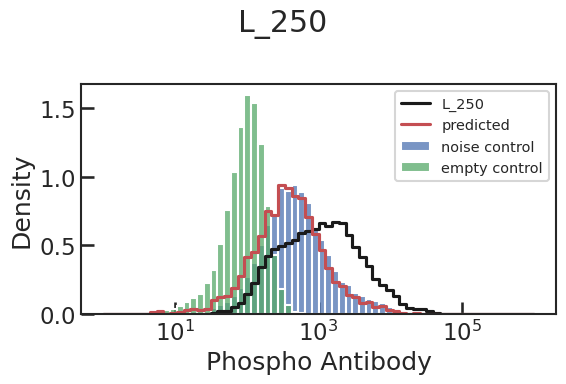

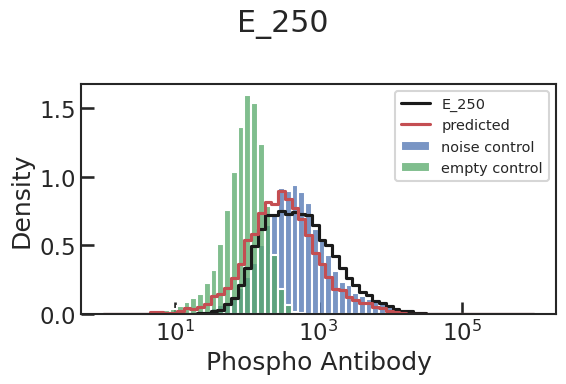

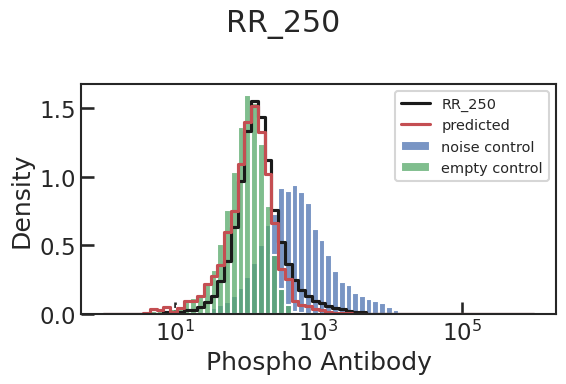

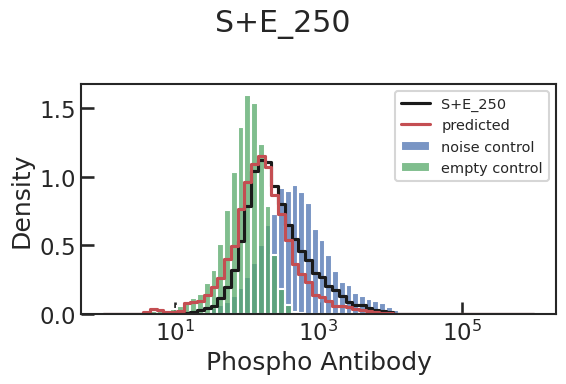

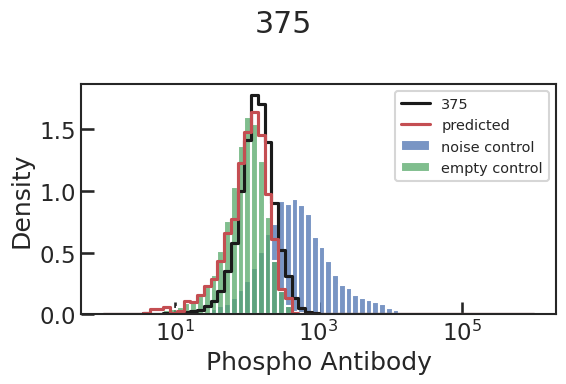

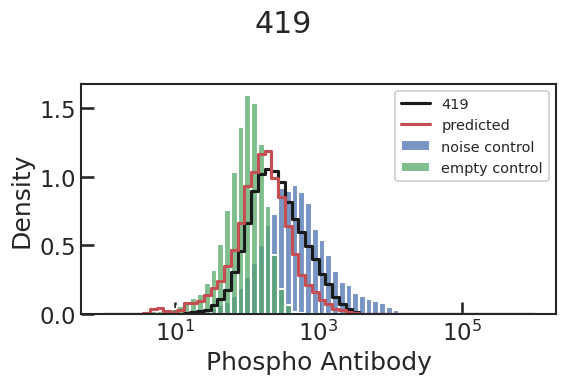

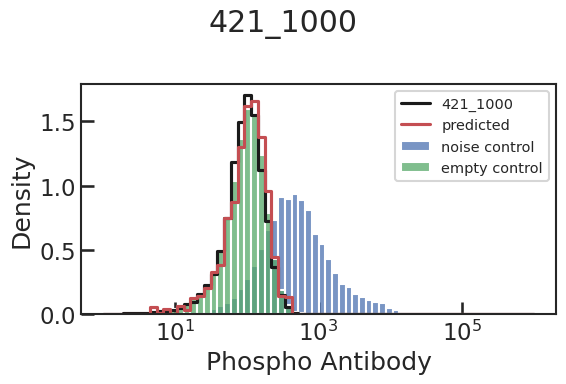

dataset   zipper kinase model  WT_empty_frac  WT_anti_scale  \
0     L_250     EE_L     wt  push       0.001320       0.336913   
1     E_250     EE_E     wt  push       0.003690       0.278620   
2    RR_250       RR     wt  push       0.000399       0.248533   
3   S+E_250      S+E     wt  push       0.002518       0.192824   
4       375  generic    375  push       0.000621       0.426397   
5       419  generic    419  push       0.006490       0.318600   
6  421_1000  generic    421  push       0.001675       0.328734   

   ST_empty_frac  ST_anti_scale  bg_phospho_rate  kinase_phospho_rate  \
0       0.003508       0.388868          0.00748            11.726074   
1       0.026181       0.273877          0.00748            11.726074   
2       0.029363       0.282584          0.00748            11.726074   
3       0.004982       0.207894          0.00748            11.726074   
4       0.001565       0.348545          0.00748             0.048100   
5       0.032397       0.346711          0.00748             0.550308   
6       0.000031       0.411817          0.00748             0.000014   

   kinase_bind_affin  
0       5.636826e-01  
1       1.265080e+04  
2       3.468099e+06  
3       4.169527e+05  
4       9.795547e+02  
5       9.795547e+02  
6       9.795547e+02

In [37]:
binrange = (0, 6)

for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.query("dataset==@dataset").copy()  
    
    model_params = 10**res.x[param_dict[dataset]]
    
    df.loc[df_tmp.index, 'SpT_conc_predict'] = pp.PushAmp().predict_all(df_tmp[['WT_conc_infer', 'ST_conc_infer']].values, model_params)[:, 0]
    df.loc[df_tmp.index, 'SpT_GFP_predict'] = df.loc[df_tmp.index, 'SpT_conc_predict'] + np.median(empty_phospho_noise.get_GFP())
    
    df.loc[df_tmp.index, 'Sp_frac_GFP_predict'] = df.loc[df_tmp.index, 'SpT_GFP_predict'] / df_tmp['ST_GFP_infer']

    
    anti, GFP_bins, anti_bins = inverse_phospho_noise.GFP_to_anti(df.loc[df_tmp.index, 'SpT_GFP_predict'])
    
    df.loc[df_tmp.index, 'SpT_anti_predict'] = anti
    
    df.loc[df_tmp.index, 'Sp_frac_conc_predict'] = df.loc[df_tmp.index, 'SpT_conc_predict'] / df_tmp['ST_conc_infer']
    
    df.loc[df_tmp.index, 'Sp_frac_anti_predict'] = df.loc[df_tmp.index, 'SpT_anti_predict'] / df.loc[df_tmp.index, 'ST_anti_exp']
    
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    
    fig.suptitle(dataset)

    
    ax = axes
    
    sns.histplot(df.loc[df_tmp.index, 'SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(df.loc[df_tmp.index, 'SpT_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='activated control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()
    
display(df_info)
    

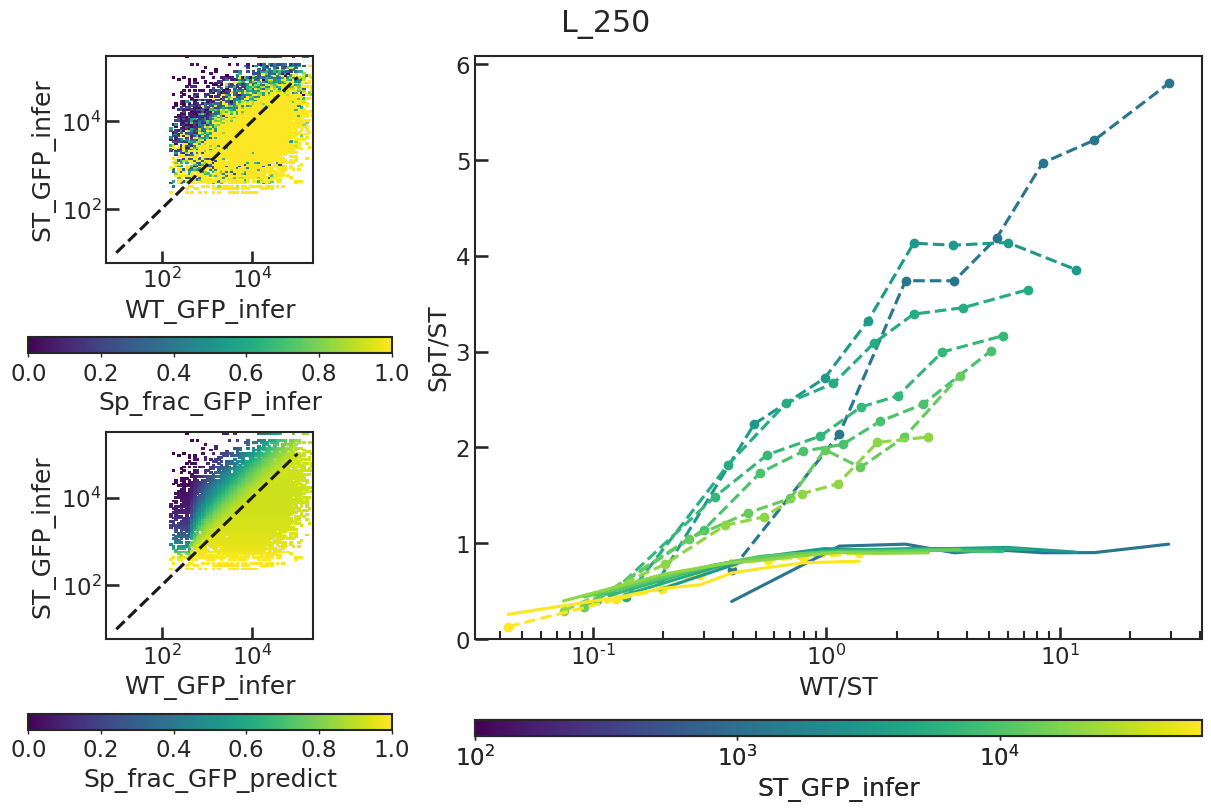

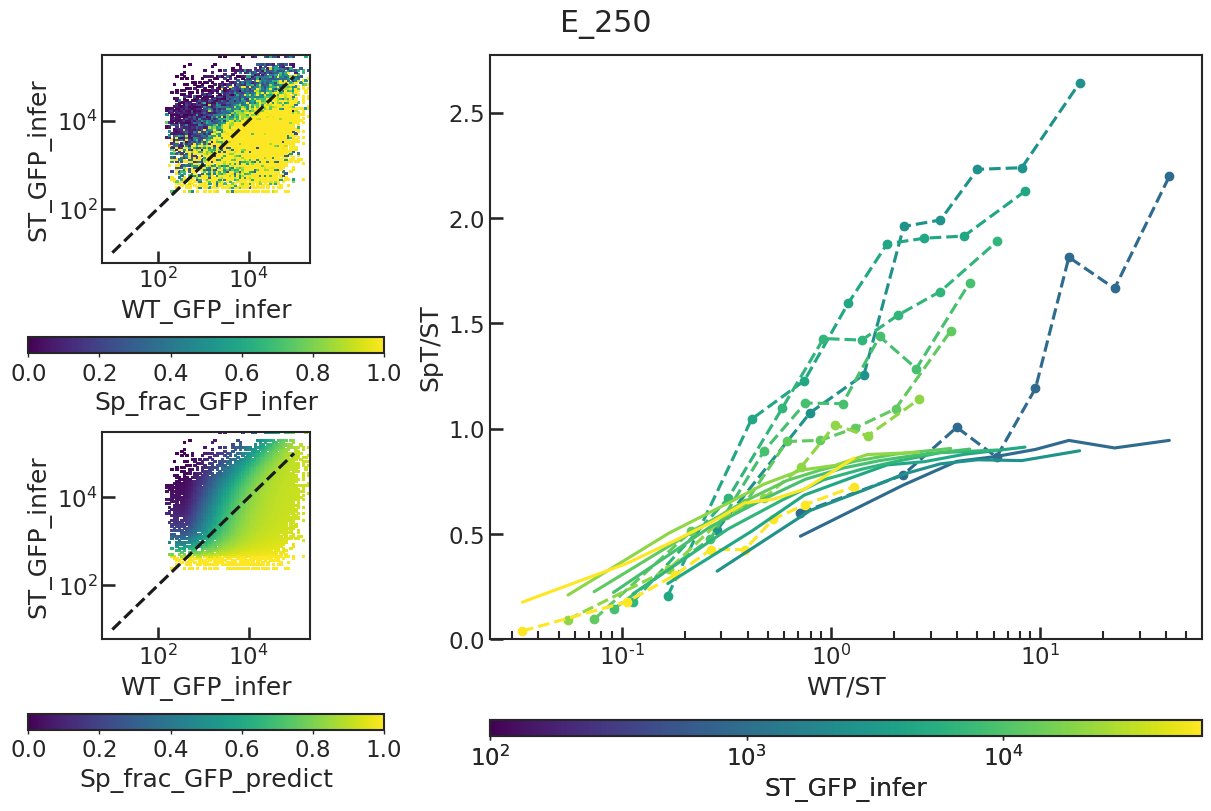

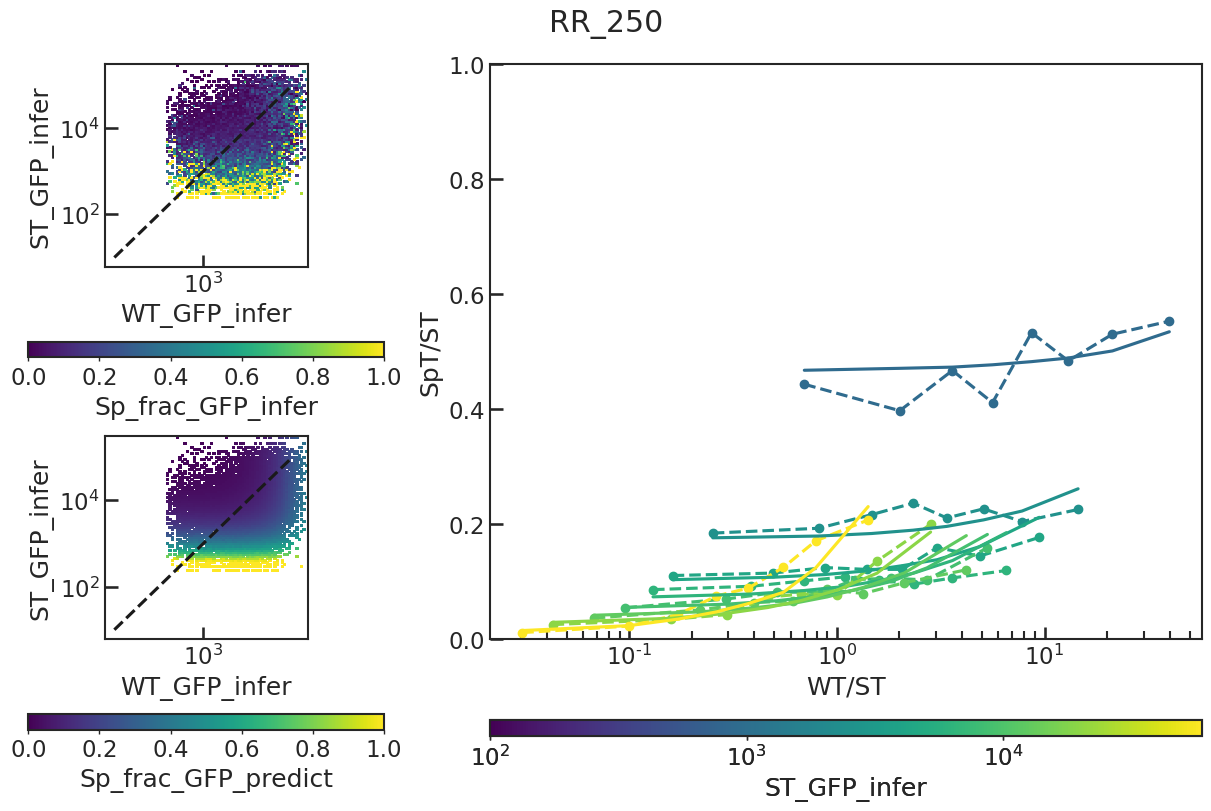

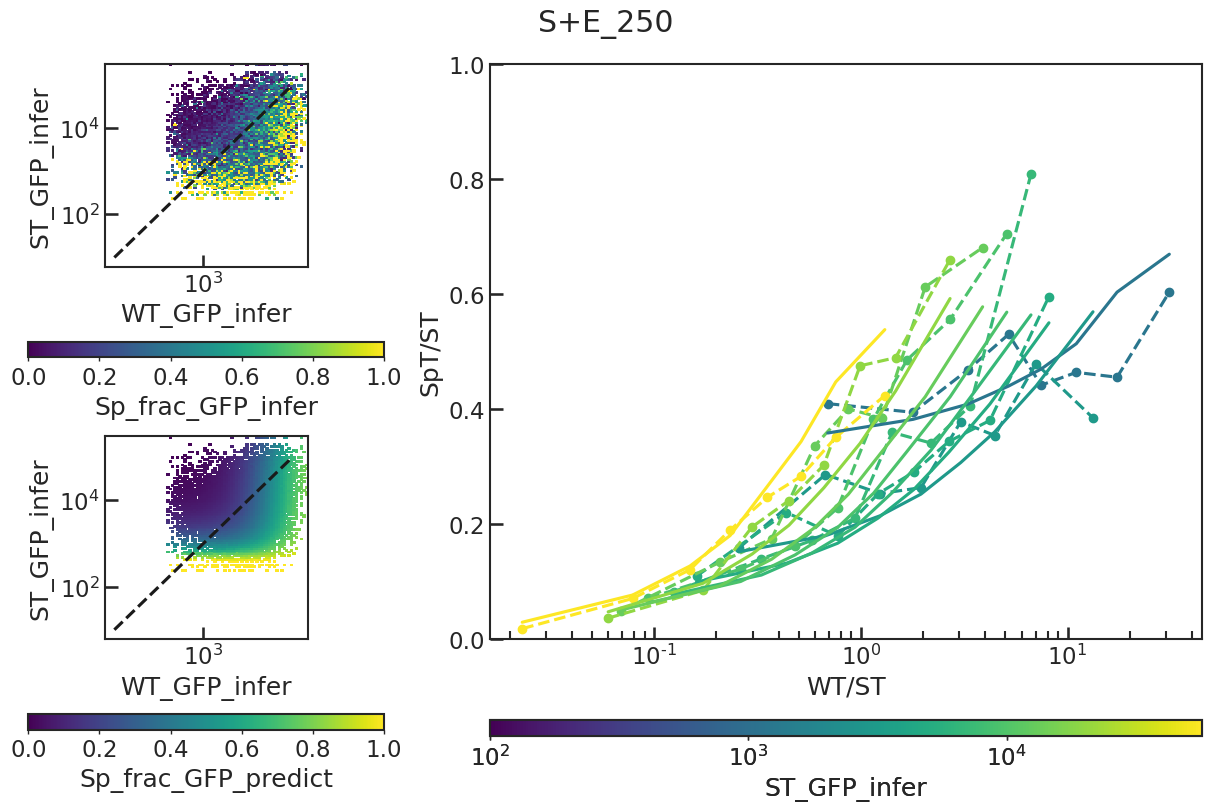

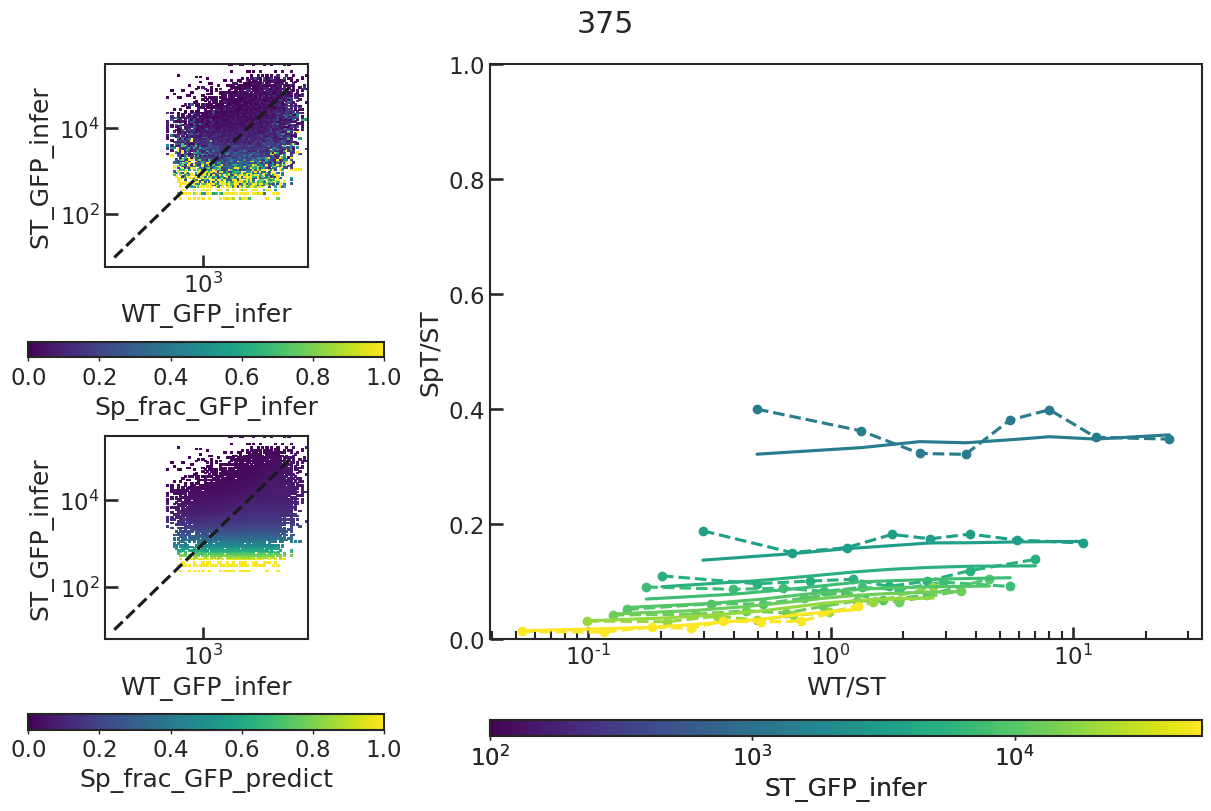

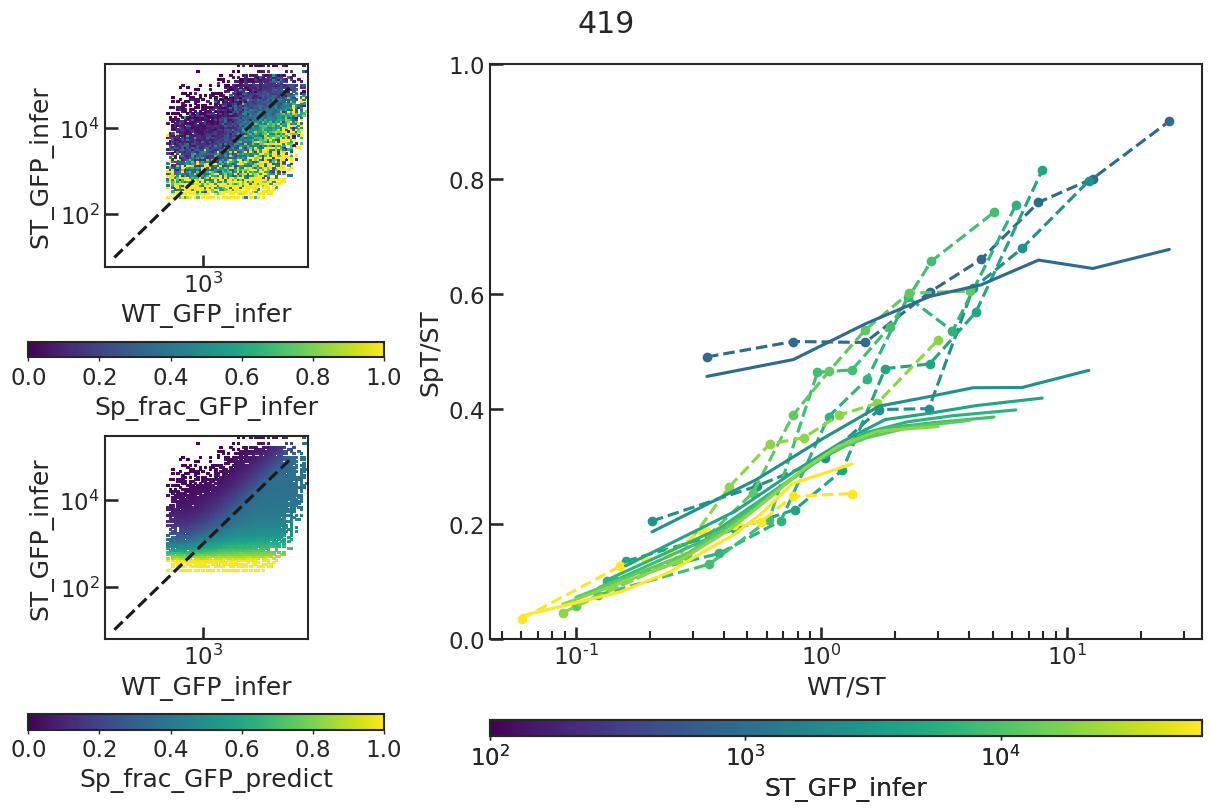

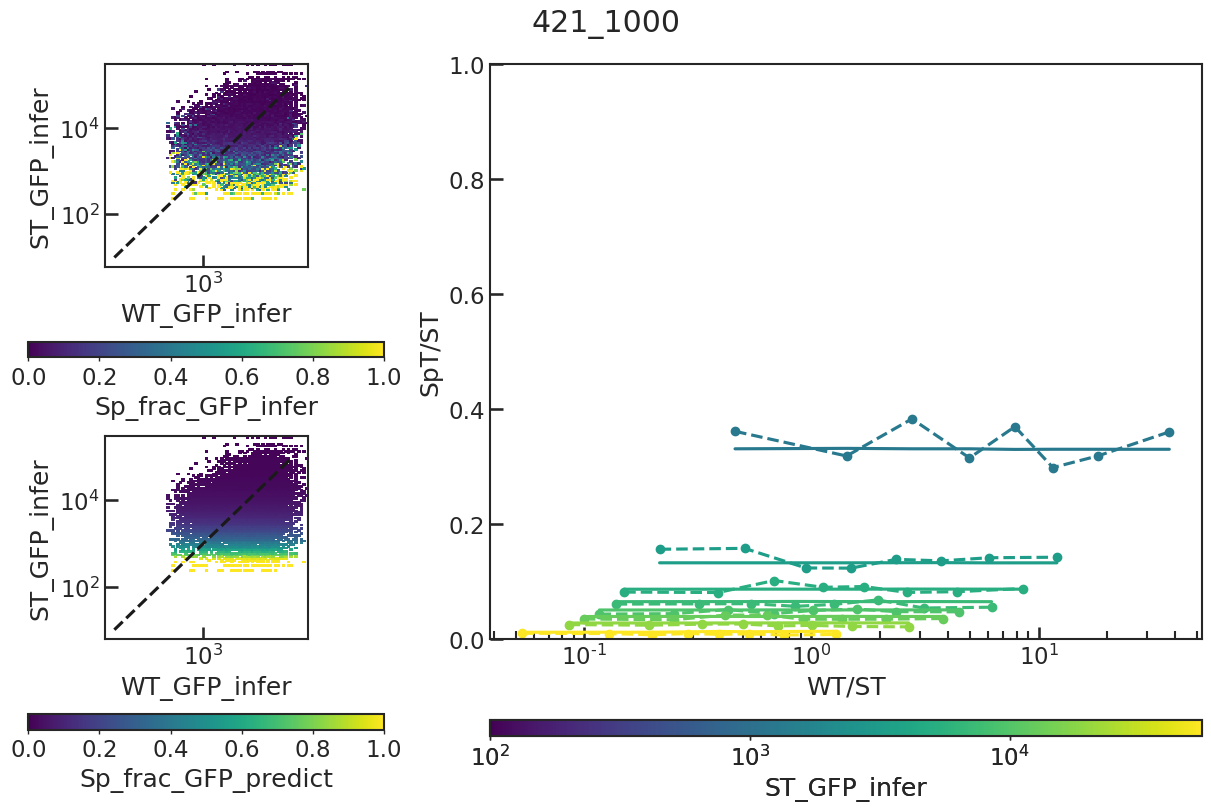

In [38]:

for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.query("dataset==@dataset").copy()    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    
    gs = fig.add_gridspec(2, 3)
    
    ##########################################################

    ax = fig.add_subplot(gs[0, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_GFP_infer', 'ST_GFP_infer', 'Sp_frac_GFP_infer',
                     vmax=1.0)

    ##########################################################   
    
    ax = fig.add_subplot(gs[1, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_GFP_infer', 'ST_GFP_infer', 'Sp_frac_GFP_predict',
                     vmax=1.0)

    
    ##########################################################
    
    ax = fig.add_subplot(gs[:, 1:3])
    
    fplot.plot_activation_curves(df_tmp, fig, ax,
                                 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_infer',
                                fmt='o--')

    fplot.plot_activation_curves(df_tmp, fig, ax,
                                 'WT_GFP_infer', 'ST_GFP_infer', 'SpT_GFP_predict',
                                fmt='-')

    
    ##########################################################

    fig.suptitle(dataset)

    plt.show()
    

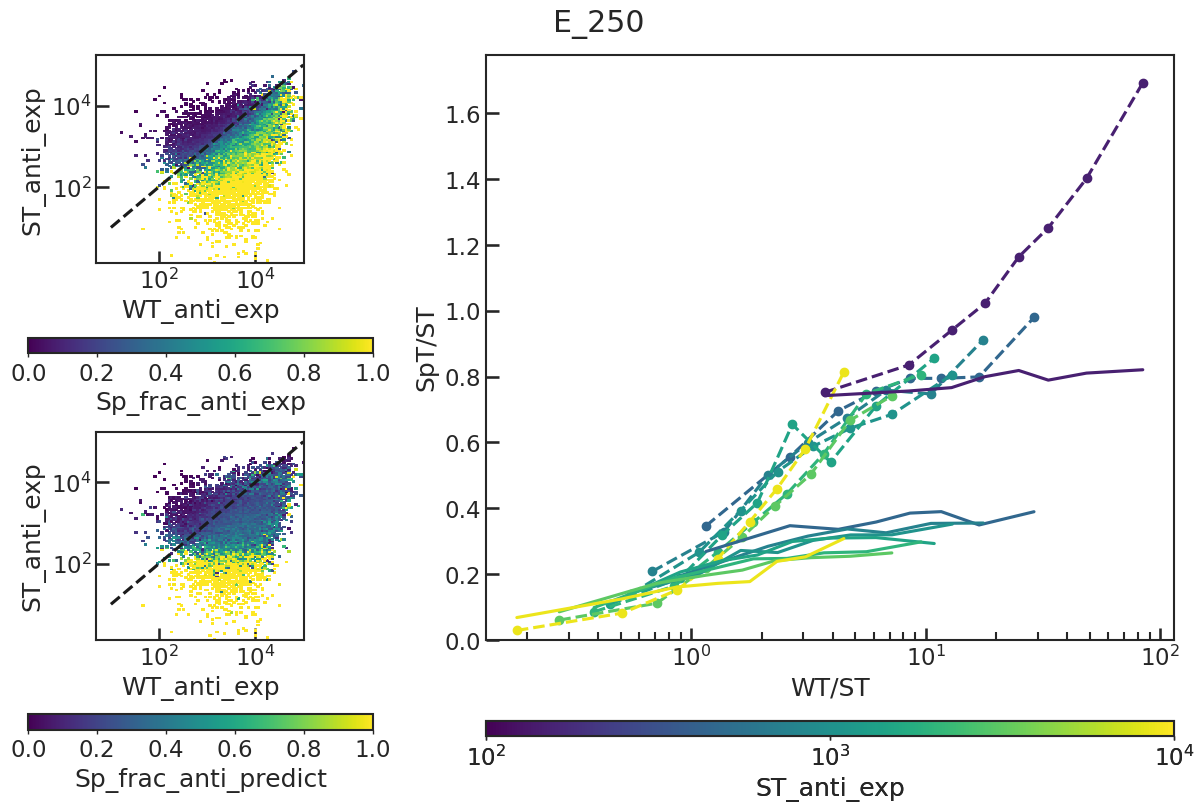

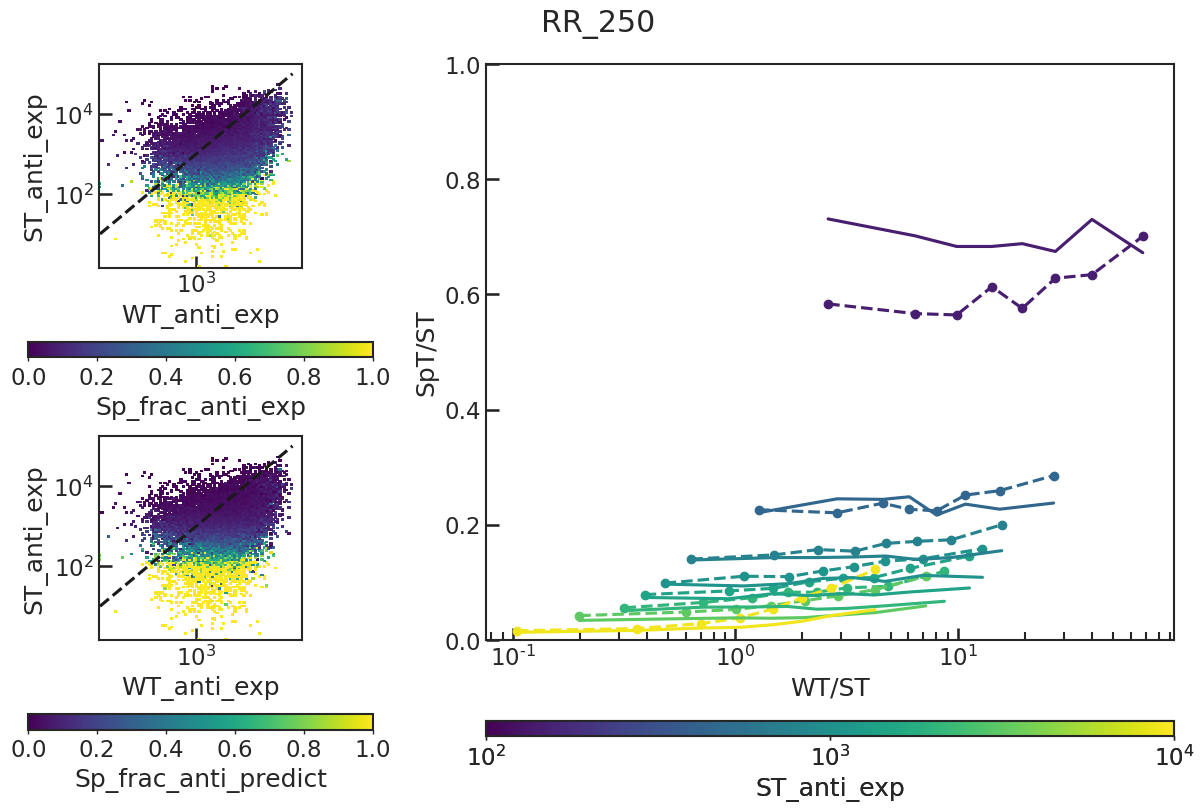

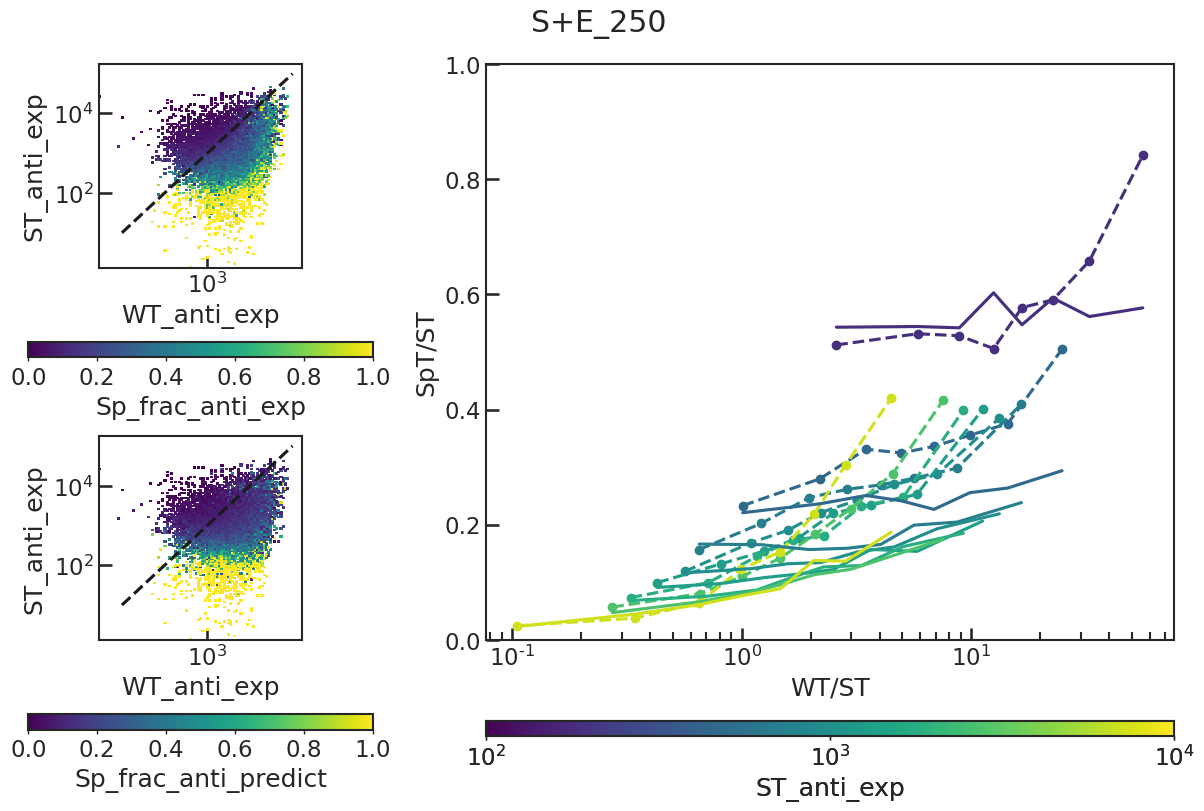

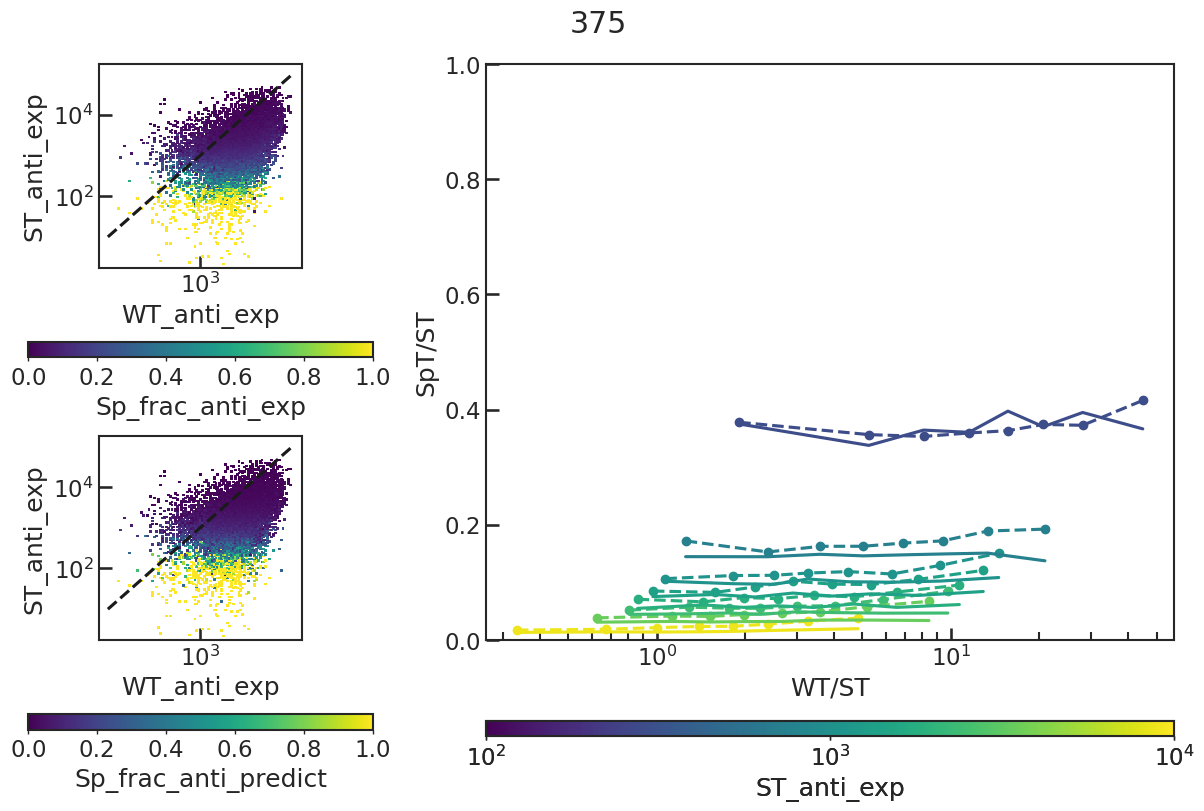

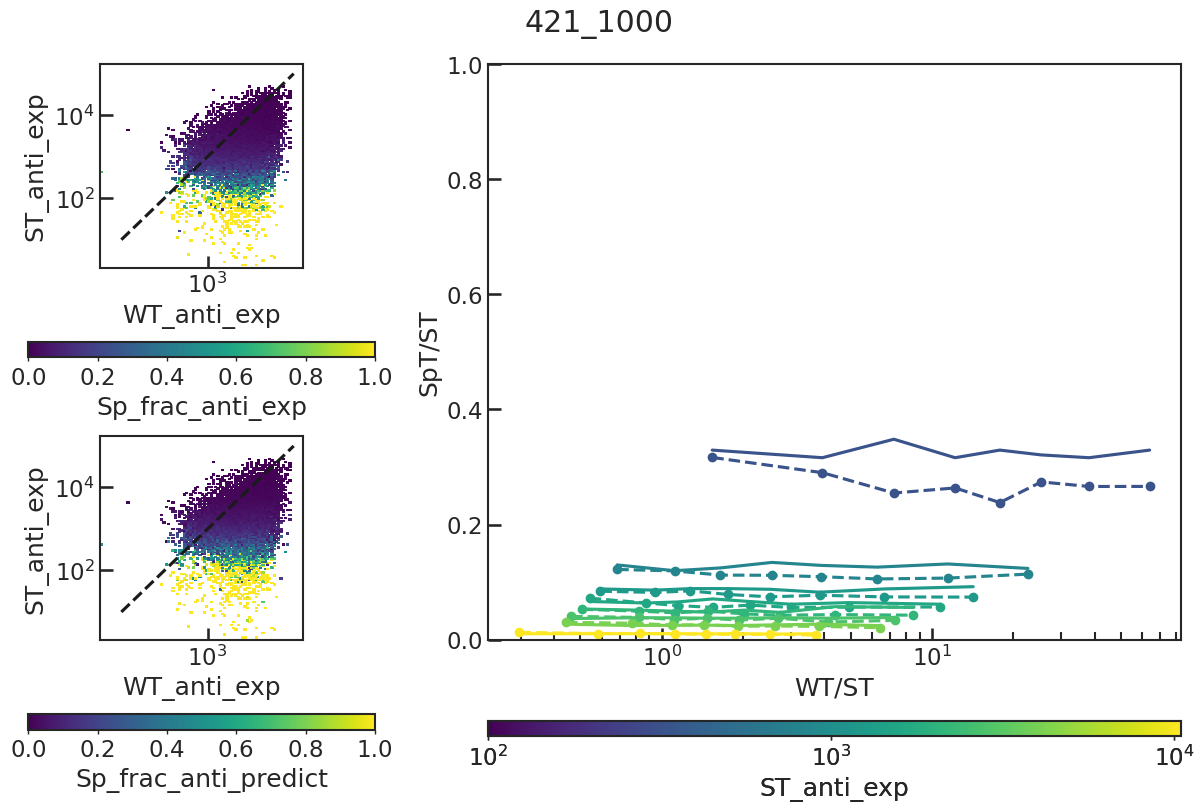

In [39]:

for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    
    df_tmp = df.query("dataset==@dataset").copy()    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    
    gs = fig.add_gridspec(2, 3)
    
    ##########################################################

    ax = fig.add_subplot(gs[0, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_anti_exp', 'ST_anti_exp', 'Sp_frac_anti_exp',
                     vmax=1.0)

    ##########################################################   
    
    ax = fig.add_subplot(gs[1, 0])
    
    fplot.plot_2d_avg(df_tmp, fig, ax, 
                      'WT_anti_exp', 'ST_anti_exp', 'Sp_frac_anti_predict',
                     vmax=1.0)

    
    ##########################################################
    
    ax = fig.add_subplot(gs[:, 1:3])
    
    fplot.plot_activation_curves(df_tmp, fig, ax,
                                 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_exp',
                                fmt='o--')

    fplot.plot_activation_curves(df_tmp, fig, ax,
                                 'WT_anti_exp', 'ST_anti_exp', 'SpT_anti_predict',
                                fmt='-')

    
    ##########################################################

    fig.suptitle(dataset)

    plt.show()
    

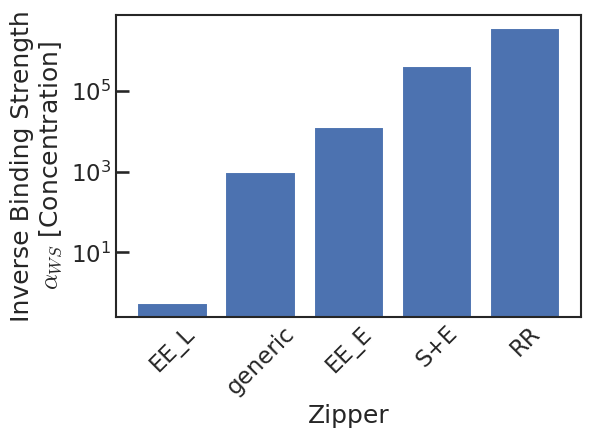

In [42]:

df_aff = df_info.groupby(['zipper']).first().sort_values('kinase_bind_affin')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.bar(df_aff.index, df_aff['kinase_bind_affin'])

ax.set_yscale('log')
ax.set_xlabel("Zipper")
ax.set_ylabel("Inverse Binding Strength\n" + r"$\alpha_{WS}$ [Concentration]")
plt.xticks(rotation=45)

plt.show()

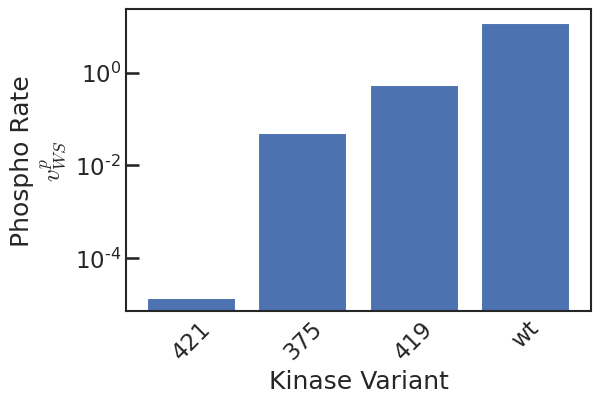

In [43]:
df_prate = df_info.groupby(['kinase']).first().sort_values('kinase_phospho_rate')


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.bar(df_prate.index, df_prate['kinase_phospho_rate'])

ax.set_yscale('log')
ax.set_xlabel("Kinase Variant")
ax.set_ylabel("Phospho Rate\n" + r"$v^p_{WS}$")
plt.xticks(rotation=45)

plt.show()